### Устанавливаем нужные библиотеки

In [ ]:
!pip install catboost optuna tsfresh

In [128]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 7.1 MB/s eta 0:00:00


In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool
import optuna

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

import lightgbm as lgbm

import shap

### Feature Engineering

In [158]:
df = pd.read_csv("/content/final_data_agg.csv",sep = ";", index_col = 0)
df.head()

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain
0,2022-09-01,3,9,0,3,96630.0,11.4,0,0
1,2022-09-02,4,9,0,3,108024.5,10.5,0,1
2,2022-09-03,5,9,0,3,122352.0,12.5,0,0
3,2022-09-04,6,9,0,3,119441.7,12.2,0,0
4,2022-09-05,0,9,0,3,87863.5,10.3,0,0


In [159]:
df["id"] = range(len(df))
extracted_features = extract_features(df, column_id='id', column_sort='time')

Feature Extraction: 100%|██████████| 3360/3360 [01:46<00:00, 31.41it/s]


In [160]:
impute(extracted_features)

The columns ['day_of_week__mean_abs_change' 'day_of_week__mean_change'
 'day_of_week__mean_second_derivative_central' ...
 'rain__permutation_entropy__dimension_7__tau_1'
 'rain__query_similarity_count__query_None__threshold_0.0'
 'rain__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.


,day_of_week__variance_larger_than_standard_deviation,day_of_week__has_duplicate_max,day_of_week__has_duplicate_min,day_of_week__has_duplicate,day_of_week__sum_values,day_of_week__abs_energy,day_of_week__mean_abs_change,day_of_week__mean_change,day_of_week__mean_second_derivative_central,day_of_week__median,...,rain__fourier_entropy__bins_5,rain__fourier_entropy__bins_10,rain__fourier_entropy__bins_100,rain__permutation_entropy__dimension_3__tau_1,rain__permutation_entropy__dimension_4__tau_1,rain__permutation_entropy__dimension_5__tau_1,rain__permutation_entropy__dimension_6__tau_1,rain__permutation_entropy__dimension_7__tau_1,rain__query_similarity_count__query_None__threshold_0.0,rain__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,3.0,9.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,4.0,16.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,5.0,25.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,6.0,36.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,6.0,36.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
extracted_features["id"] = range(len(df))

In [162]:
df = pd.merge(df, extracted_features, on='id')
df.drop("id", axis = 1, inplace = True)
df.head()

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain,day_of_week__variance_larger_than_standard_deviation,...,rain__fourier_entropy__bins_5,rain__fourier_entropy__bins_10,rain__fourier_entropy__bins_100,rain__permutation_entropy__dimension_3__tau_1,rain__permutation_entropy__dimension_4__tau_1,rain__permutation_entropy__dimension_5__tau_1,rain__permutation_entropy__dimension_6__tau_1,rain__permutation_entropy__dimension_7__tau_1,rain__query_similarity_count__query_None__threshold_0.0,rain__mean_n_absolute_max__number_of_maxima_7
0,2022-09-01,3,9,0,3,96630.0,11.4,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-09-02,4,9,0,3,108024.5,10.5,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-03,5,9,0,3,122352.0,12.5,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-09-04,6,9,0,3,119441.7,12.2,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-09-05,0,9,0,3,87863.5,10.3,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
def drop_uninformative(data, threshold = 0.99):
  count = 0
  for column in data.columns:
    max_freq = data[column].value_counts(normalize=True).max()
    if max_freq >= threshold:
      data.drop(column, axis=1, inplace=True)
      count += 1

  print(f"{count} колонок удалено")


In [164]:
drop_uninformative(df)

6056 колонок удалено


In [165]:
for i in range(1, 8):
  df[i] = df["revenue"].shift(i)

df.head()

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain,day_of_week__sum_values,...,rain__value_count__value_1,rain__range_count__max_1__min_-1,rain__count_below__t_0,1,2,3,4,5,6,7
0,2022-09-01,3,9,0,3,96630.0,11.4,0,0,3.0,...,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,4,9,0,3,108024.5,10.5,0,1,4.0,...,1.0,0.0,0.0,96630.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-03,5,9,0,3,122352.0,12.5,0,0,5.0,...,0.0,1.0,1.0,108024.5,96630.0,NaN,NaN,NaN,NaN,NaN
3,2022-09-04,6,9,0,3,119441.7,12.2,0,0,6.0,...,0.0,1.0,1.0,122352.0,108024.5,96630.0,NaN,NaN,NaN,NaN
4,2022-09-05,0,9,0,3,87863.5,10.3,0,0,0.0,...,0.0,1.0,1.0,119441.7,122352.0,108024.5,96630.0,NaN,NaN,NaN


In [166]:
df.dropna(inplace = True)
df.shape

(413, 224)

In [167]:
df.reset_index(drop = True, inplace = True)

In [179]:
def remove_highly_correlated_features(df, threshold=0.8):
    # Вычисление матрицы корреляций, устанавливая numeric_only=True
    corr_matrix = df.corr(numeric_only=True).abs()

    # Выбор верхнего треугольника матрицы корреляций
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)
    )

    # Нахождение индексов колонок с корреляцией больше, чем threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Удаление колонок
    df_reduced = df.drop(to_drop, axis=1)

    return df_reduced, to_drop

# Использование функции
df, dropped_features = remove_highly_correlated_features(df, threshold=0.7)
if dropped_features:
    print("Dropped columns:", dropped_features)
else:
    print("No columns were dropped.")


Dropped columns: ['month__benford_correlation', 'season__value_count__value_0', 'avg_temp__fft_coefficient__attr_"angle"__coeff_0']


In [180]:
df.shape

(413, 23)

In [181]:
df

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain,day_of_week__benford_correlation,...,revenue__benford_correlation,avg_temp__benford_correlation,avg_temp__range_count__max_1__min_-1,1,2,3,4,5,6,7
0,2022-09-08,3,9,0,3,91541.00,9.2,0,1,0.062915,...,-0.297356,-0.297356,0.0,117891.75,104438.50,87863.50,119441.70,122352.00,108024.5,96630.0
1,2022-09-09,4,9,0,3,124681.88,10.2,0,0,-0.064614,...,0.864123,0.864123,0.0,91541.00,117891.75,104438.50,87863.50,119441.70,122352.0,108024.5
2,2022-09-10,5,9,0,3,130622.00,12.1,0,0,-0.145280,...,0.864123,0.864123,0.0,124681.88,91541.00,117891.75,104438.50,87863.50,119441.7,122352.0
3,2022-09-11,6,9,0,3,118543.00,13.0,0,0,-0.200946,...,0.864123,0.864123,0.0,130622.00,124681.88,91541.00,117891.75,104438.50,87863.5,119441.7
4,2022-09-12,0,9,0,3,88454.00,12.0,0,1,0.062915,...,-0.272809,0.864123,0.0,118543.00,130622.00,124681.88,91541.00,117891.75,104438.5,87863.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,2023-10-22,6,10,0,3,138996.12,2.6,1,0,-0.200946,...,0.864123,0.295657,0.0,150704.60,106856.00,62522.00,75438.50,94493.00,83683.0,104129.5
409,2023-10-23,0,10,0,3,61260.00,4.4,0,1,0.062915,...,-0.200946,-0.064614,0.0,138996.12,150704.60,106856.00,62522.00,75438.50,94493.0,83683.0
410,2023-10-24,1,10,0,3,70993.00,1.4,0,1,0.864123,...,-0.241690,0.864123,0.0,61260.00,138996.12,150704.60,106856.00,62522.00,75438.5,94493.0
411,2023-10-25,2,10,0,3,85317.97,-0.3,0,0,0.295657,...,-0.272809,0.062915,1.0,70993.00,61260.00,138996.12,150704.60,106856.00,62522.0,75438.5


In [182]:
train_size = int(len(df) * 0.6)
test_size = int(len(df) * 0.2)
val_size = int(len(df) * 0.2)

train_index = list(range(0, train_size))
val_index = list(range(train_size, train_size + val_size))
test_index = list(range(train_size + val_size, len(df)))

train = df[:train_size]
val = df[train_size:]
test = df[train_size: ]

In [ ]:
train_size, test_size, val_size
train_index, val_index, test_index

In [184]:
X_train, y_train = df.loc[train_index].drop(["revenue", "time"], axis = 1), df.loc[train_index]["revenue"]
X_val, y_val = df.loc[val_index].drop(["revenue", "time"], axis = 1), df.loc[val_index]["revenue"]
X_test, y_test = df.loc[test_index].drop(["revenue", "time"], axis = 1), df.loc[test_index]["revenue"]

In [199]:
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

### Обучаем модельки

#### Обучаем CatBoost

In [222]:
catboost_model = CatBoostRegressor(verbose=0)
catboost_model.fit(X_train, y_train)
catboost_prediction = catboost_model.predict(X_val)
print(f"RMSE = {np.sqrt(mean_squared_error(y_val, catboost_prediction))}")
feature = pd.DataFrame()
feature["feature"] = X_train.columns
feature["importances"] = catboost_model.feature_importances_
feature.sort_values(by = "importances", ascending = False).reset_index(drop = True)

RMSE = 13375.495362117716


,feature,importances
0,revenue__benford_correlation,70.479871
1,season,3.188837
2,6,2.885260
3,7,2.486068
4,day_of_week,2.307029
5,avg_temp,2.244685
6,2,2.190346
7,5,2.118752
8,day_of_week__benford_correlation,1.923007
9,season__benford_correlation,1.901306


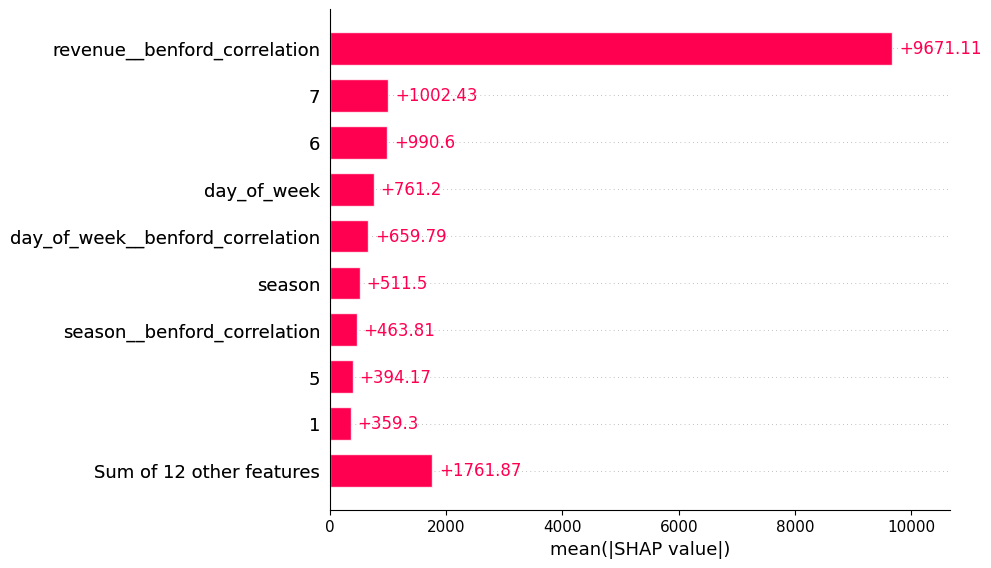

In [202]:
explainer = shap.Explainer(catboost_model, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))

#### Обучаем LIghtGBM

In [223]:
train_data = lgbm.Dataset(X_train, label=y_train)
val_data = lgbm.Dataset(X_val, label=y_val, reference=train_data)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': 0
}

lgbm_model = lgbm.train(params, train_data, valid_sets = [val_data], callbacks=[lgbm.early_stopping(stopping_rounds=10)], num_boost_round=1000)
lgbm_prediction = lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)
print(f"RMSE = {np.sqrt(mean_squared_error(y_val, lgbm_prediction))}")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

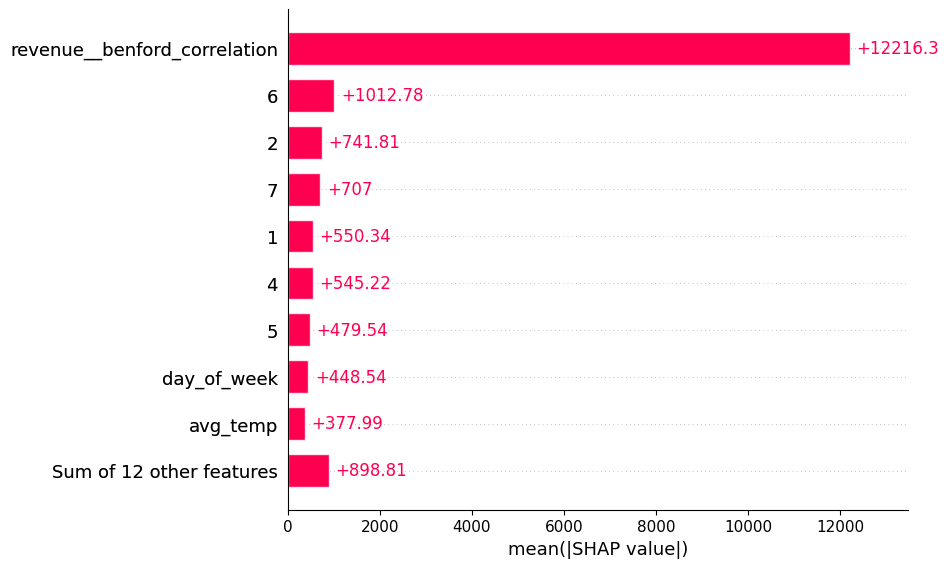

In [216]:
explainer = shap.Explainer(lgbm_model, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))

#### Обучаем RandomForest

In [224]:
randforest_model = RandomForestRegressor(max_depth = 6, n_estimators=100, bootstrap=True)
randforest_model.fit(X_train, y_train)
randforest_prediction = randforest_model.predict(X_val)
print(f"RMSE = {np.sqrt(mean_squared_error(y_val, randforest_prediction))}")

RMSE = 12459.75131167605


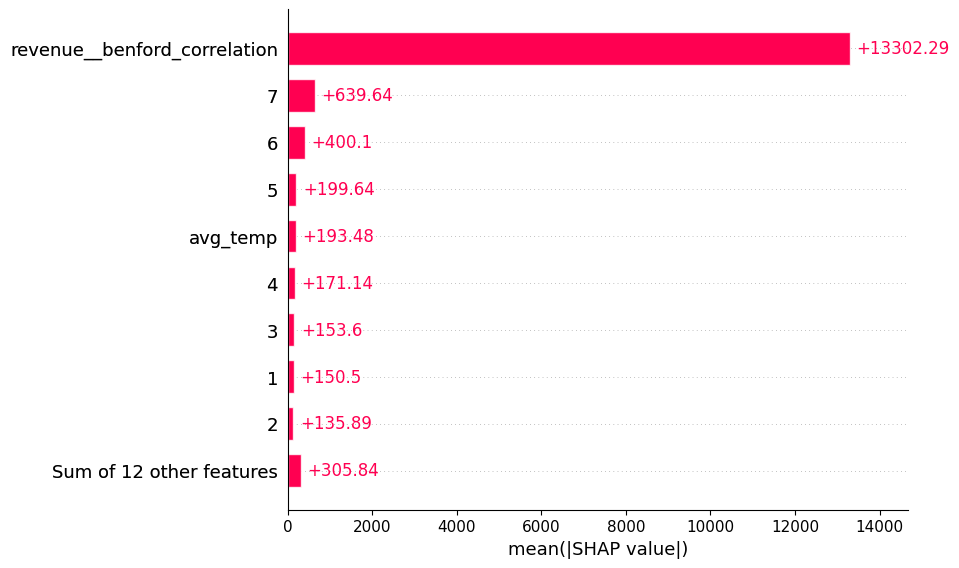

In [221]:
explainer = shap.Explainer(randforest_model, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))

#### Обучаем мета алгоритм

In [234]:
meta_pred = pd.DataFrame({"catboost": catboost_prediction,
                          "lightgbm": lgbm_prediction,
                          "random_forest": randforest_prediction})
meta_pred["final_pred"] = meta_pred[["catboost", "lightgbm", "random_forest"]].mean(axis = 1)
meta_prediction = meta_pred["final_pred"]
print(f"RMSE = {np.sqrt(mean_squared_error(y_val, meta_prediction))}")

RMSE = 12599.51561153561


In [194]:
best_feature = feature['feature'].values
best_feature

array(['day_of_week', 'month', 'salary_week', 'season', 'avg_temp',
       'snow', 'rain', 'day_of_week__benford_correlation',
       'day_of_week__value_count__value_0', 'month__value_count__value_1',
       'season__benford_correlation', 'revenue__benford_correlation',
       'avg_temp__benford_correlation',
       'avg_temp__range_count__max_1__min_-1', 1, 2, 3, 4, 5, 6, 7],
      dtype=object)

In [ ]:
def objective(trial):
  params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 15),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'RMSE',
        'verbose': False
    }

  train_pool = Pool(data=X_train, label=y_train)
  model = CatBoostRegressor(**params)
  model.fit(X_train, y_train)
  score = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))
  return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [116]:
print('Лучшие параметры:', study.best_params)
print("Лучший скор: ", study.best_value)

Лучшие параметры: {'iterations': 1043, 'depth': 4, 'learning_rate': 0.02170479986962061, 'l2_leaf_reg': 1.4191906239018095, 'border_count': 226}
Лучший скор:  7480.957658467725


In [119]:
params = study.best_params
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, verbose=0)
round((np.sqrt(mean_squared_error(y_test, model.predict(X_test)))), 3)

1710.714

In [120]:
def metric(y_pred, y_test):
  #print(f"======= Резултаты {model_name} =======")
  print()
  print("RMSE = ", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))
  print("MAE = ", round(mean_absolute_error(y_test, y_pred),3))
  print("MAPE = ", round(mean_absolute_percentage_error(y_test, y_pred),3))
  print()

In [121]:
predictions = model.predict(X_test)
metric(predictions, y_test)


RMSE =  1710.714
MAE =  799.225
MAPE =  0.009



#### Тюнинг мета алгоритма

In [238]:
def objective(trial):
    # LightGBM параметры
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('lgb_num_leaves', 31, 256),
        'learning_rate': trial.suggest_loguniform('lgb_learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 1000),
    }

    # Создание объектов Dataset для LightGBM
    lgb_train = lgbm.Dataset(X_train, y_train)
    lgb_val = lgbm.Dataset(X_val, y_val, reference=lgb_train)

    # Обучение LightGBM модели
    lgb_model = lgbm.train(lgb_params, lgb_train, valid_sets=[lgb_val], callbacks=[lgbm.early_stopping(stopping_rounds=10)])

    # Параметры для CatBoost
    cb_params = {
        'loss_function': 'RMSE',
        'iterations': trial.suggest_int('cb_iterations', 100, 1000),
        'learning_rate': trial.suggest_float('cb_learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('cb_depth', 4, 10),
    }
    cb_model = CatBoostRegressor(**cb_params, verbose=0)
    cb_model.fit(X_train, y_train)

    # Параметры для RandomForest
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('rf_max_depth', 5, 30),
    }
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train, y_train)

    # Метапредсказание
    lgb_pred = lgb_model.predict(X_val)
    cb_pred = cb_model.predict(X_val)
    rf_pred = rf_model.predict(X_val)

    final_pred = np.mean([lgb_pred, cb_pred, rf_pred], axis=0)

    # Вычисление RMSE
    rmse = np.sqrt(mean_squared_error(y_val, final_pred))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

print('Best params', study.best_params)
print("Best score", study.best_value)

[I 2024-02-03 22:23:27,936] A new study created in memory with name: no-name-3ee10cf5-19c0-4523-8569-32ad4c6e5523
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 12441.5


[I 2024-02-03 22:23:29,197] Trial 0 finished with value: 12776.540926177231 and parameters: {'lgb_num_leaves': 165, 'lgb_learning_rate': 0.2914772347586281, 'lgb_n_estimators': 559, 'cb_iterations': 429, 'cb_learning_rate': 0.1809332351616871, 'cb_depth': 5, 'rf_n_estimators': 259, 'rf_max_depth': 6}. Best is trial 0 with value: 12776.540926177231.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's rmse: 12378.1


[I 2024-02-03 22:23:32,132] Trial 1 finished with value: 12500.834295622173 and parameters: {'lgb_num_leaves': 90, 'lgb_learning_rate': 0.10279914682905007, 'lgb_n_estimators': 479, 'cb_iterations': 362, 'cb_learning_rate': 0.11202564925587837, 'cb_depth': 4, 'rf_n_estimators': 805, 'rf_max_depth': 12}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[91]	valid_0's rmse: 12454.4


[I 2024-02-03 22:23:34,843] Trial 2 finished with value: 12861.062219217427 and parameters: {'lgb_num_leaves': 222, 'lgb_learning_rate': 0.0728816694308448, 'lgb_n_estimators': 878, 'cb_iterations': 152, 'cb_learning_rate': 0.18311728708412253, 'cb_depth': 8, 'rf_n_estimators': 416, 'rf_max_depth': 19}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[350]	valid_0's rmse: 12791


[I 2024-02-03 22:23:41,390] Trial 3 finished with value: 12833.223488533413 and parameters: {'lgb_num_leaves': 226, 'lgb_learning_rate': 0.01073281356109691, 'lgb_n_estimators': 350, 'cb_iterations': 722, 'cb_learning_rate': 0.23987010837388723, 'cb_depth': 8, 'rf_n_estimators': 745, 'rf_max_depth': 11}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 12540.6


[I 2024-02-03 22:23:50,021] Trial 4 finished with value: 12971.753055054065 and parameters: {'lgb_num_leaves': 59, 'lgb_learning_rate': 0.12439713941214296, 'lgb_n_estimators': 577, 'cb_iterations': 931, 'cb_learning_rate': 0.08259539416160468, 'cb_depth': 8, 'rf_n_estimators': 576, 'rf_max_depth': 20}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 12376.5


[I 2024-02-03 22:23:57,597] Trial 5 finished with value: 12938.795064006805 and parameters: {'lgb_num_leaves': 89, 'lgb_learning_rate': 0.16151739851040392, 'lgb_n_estimators': 442, 'cb_iterations': 240, 'cb_learning_rate': 0.07866642899248899, 'cb_depth': 10, 'rf_n_estimators': 839, 'rf_max_depth': 14}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's rmse: 12485.6


[I 2024-02-03 22:23:59,827] Trial 6 finished with value: 12606.735115284566 and parameters: {'lgb_num_leaves': 188, 'lgb_learning_rate': 0.05279298125825583, 'lgb_n_estimators': 152, 'cb_iterations': 697, 'cb_learning_rate': 0.2326709118855979, 'cb_depth': 4, 'rf_n_estimators': 423, 'rf_max_depth': 19}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 12324.5


[I 2024-02-03 22:24:02,184] Trial 7 finished with value: 12621.126092282633 and parameters: {'lgb_num_leaves': 150, 'lgb_learning_rate': 0.2783296062375889, 'lgb_n_estimators': 203, 'cb_iterations': 205, 'cb_learning_rate': 0.1421142968517361, 'cb_depth': 6, 'rf_n_estimators': 703, 'rf_max_depth': 13}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[364]	valid_0's rmse: 12462.4


[I 2024-02-03 22:24:03,405] Trial 8 finished with value: 12790.445373450357 and parameters: {'lgb_num_leaves': 215, 'lgb_learning_rate': 0.01735112701978935, 'lgb_n_estimators': 977, 'cb_iterations': 236, 'cb_learning_rate': 0.2905253417590445, 'cb_depth': 5, 'rf_n_estimators': 287, 'rf_max_depth': 12}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's rmse: 12507.8


[I 2024-02-03 22:24:04,107] Trial 9 finished with value: 12589.21488609226 and parameters: {'lgb_num_leaves': 209, 'lgb_learning_rate': 0.04710184694600826, 'lgb_n_estimators': 399, 'cb_iterations': 355, 'cb_learning_rate': 0.15133437239606418, 'cb_depth': 4, 'rf_n_estimators': 109, 'rf_max_depth': 22}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[225]	valid_0's rmse: 12465.2


[I 2024-02-03 22:24:18,914] Trial 10 finished with value: 13088.730755549559 and parameters: {'lgb_num_leaves': 102, 'lgb_learning_rate': 0.03044868930920624, 'lgb_n_estimators': 729, 'cb_iterations': 555, 'cb_learning_rate': 0.034417132621255106, 'cb_depth': 10, 'rf_n_estimators': 981, 'rf_max_depth': 29}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's rmse: 12454


[I 2024-02-03 22:24:19,736] Trial 11 finished with value: 12603.705418960622 and parameters: {'lgb_num_leaves': 31, 'lgb_learning_rate': 0.054688308100376025, 'lgb_n_estimators': 346, 'cb_iterations': 412, 'cb_learning_rate': 0.12087748232938703, 'cb_depth': 4, 'rf_n_estimators': 118, 'rf_max_depth': 25}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 12540.4


[I 2024-02-03 22:24:24,143] Trial 12 finished with value: 12748.346806425752 and parameters: {'lgb_num_leaves': 115, 'lgb_learning_rate': 0.0946874333894087, 'lgb_n_estimators': 718, 'cb_iterations': 376, 'cb_learning_rate': 0.1059074235634952, 'cb_depth': 6, 'rf_n_estimators': 995, 'rf_max_depth': 24}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's rmse: 12476.2


[I 2024-02-03 22:24:26,152] Trial 13 finished with value: 12550.676922100987 and parameters: {'lgb_num_leaves': 128, 'lgb_learning_rate': 0.03771330790395772, 'lgb_n_estimators': 431, 'cb_iterations': 536, 'cb_learning_rate': 0.16975530253759472, 'cb_depth': 4, 'rf_n_estimators': 571, 'rf_max_depth': 8}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[258]	valid_0's rmse: 12492


[I 2024-02-03 22:24:28,637] Trial 14 finished with value: 12588.331880222637 and parameters: {'lgb_num_leaves': 125, 'lgb_learning_rate': 0.0234392767336485, 'lgb_n_estimators': 664, 'cb_iterations': 558, 'cb_learning_rate': 0.018787804812167297, 'cb_depth': 6, 'rf_n_estimators': 559, 'rf_max_depth': 5}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's rmse: 12484.1


[I 2024-02-03 22:24:31,455] Trial 15 finished with value: 12761.582080432023 and parameters: {'lgb_num_leaves': 72, 'lgb_learning_rate': 0.0355479492165932, 'lgb_n_estimators': 259, 'cb_iterations': 663, 'cb_learning_rate': 0.20432628063108696, 'cb_depth': 5, 'rf_n_estimators': 699, 'rf_max_depth': 9}. Best is trial 1 with value: 12500.834295622173.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 12318.1


[I 2024-02-03 22:24:35,436] Trial 16 finished with value: 12451.494298902402 and parameters: {'lgb_num_leaves': 143, 'lgb_learning_rate': 0.16799195775624015, 'lgb_n_estimators': 505, 'cb_iterations': 861, 'cb_learning_rate': 0.06360305695896792, 'cb_depth': 4, 'rf_n_estimators': 859, 'rf_max_depth': 16}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 12395.4


[I 2024-02-03 22:24:41,220] Trial 17 finished with value: 12767.799211785117 and parameters: {'lgb_num_leaves': 156, 'lgb_learning_rate': 0.1787647632643027, 'lgb_n_estimators': 501, 'cb_iterations': 949, 'cb_learning_rate': 0.05282318506259988, 'cb_depth': 7, 'rf_n_estimators': 872, 'rf_max_depth': 16}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 12420.8


[I 2024-02-03 22:24:44,699] Trial 18 finished with value: 12642.246363378348 and parameters: {'lgb_num_leaves': 248, 'lgb_learning_rate': 0.0977128977716867, 'lgb_n_estimators': 607, 'cb_iterations': 825, 'cb_learning_rate': 0.06451541760605126, 'cb_depth': 5, 'rf_n_estimators': 841, 'rf_max_depth': 16}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 12300.4


[I 2024-02-03 22:24:51,407] Trial 19 finished with value: 12737.783161736937 and parameters: {'lgb_num_leaves': 38, 'lgb_learning_rate': 0.18959942382117168, 'lgb_n_estimators': 292, 'cb_iterations': 827, 'cb_learning_rate': 0.10702449740320923, 'cb_depth': 7, 'rf_n_estimators': 891, 'rf_max_depth': 16}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's rmse: 12548.2


[I 2024-02-03 22:24:54,459] Trial 20 finished with value: 12675.69893460356 and parameters: {'lgb_num_leaves': 181, 'lgb_learning_rate': 0.07928331558385575, 'lgb_n_estimators': 804, 'cb_iterations': 994, 'cb_learning_rate': 0.13085094960884283, 'cb_depth': 4, 'rf_n_estimators': 763, 'rf_max_depth': 10}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 12371.1


[I 2024-02-03 22:24:56,606] Trial 21 finished with value: 12631.750596826234 and parameters: {'lgb_num_leaves': 131, 'lgb_learning_rate': 0.1320052589838285, 'lgb_n_estimators': 468, 'cb_iterations': 541, 'cb_learning_rate': 0.16774574881922324, 'cb_depth': 4, 'rf_n_estimators': 619, 'rf_max_depth': 8}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[160]	valid_0's rmse: 12506.8


[I 2024-02-03 22:24:59,181] Trial 22 finished with value: 12659.117028617178 and parameters: {'lgb_num_leaves': 95, 'lgb_learning_rate': 0.03768537248075945, 'lgb_n_estimators': 501, 'cb_iterations': 458, 'cb_learning_rate': 0.09150041026728203, 'cb_depth': 5, 'rf_n_estimators': 496, 'rf_max_depth': 13}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 12478.8


[I 2024-02-03 22:25:01,683] Trial 23 finished with value: 12511.95320906783 and parameters: {'lgb_num_leaves': 138, 'lgb_learning_rate': 0.07558812399962563, 'lgb_n_estimators': 380, 'cb_iterations': 315, 'cb_learning_rate': 0.04603712047065037, 'cb_depth': 4, 'rf_n_estimators': 671, 'rf_max_depth': 8}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's rmse: 12514.3


[I 2024-02-03 22:25:04,044] Trial 24 finished with value: 12799.867352541298 and parameters: {'lgb_num_leaves': 78, 'lgb_learning_rate': 0.06698658846886034, 'lgb_n_estimators': 346, 'cb_iterations': 319, 'cb_learning_rate': 0.010171872748558852, 'cb_depth': 6, 'rf_n_estimators': 659, 'rf_max_depth': 7}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 12463.1


[I 2024-02-03 22:25:06,497] Trial 25 finished with value: 12604.36985014068 and parameters: {'lgb_num_leaves': 174, 'lgb_learning_rate': 0.11657769450844081, 'lgb_n_estimators': 117, 'cb_iterations': 149, 'cb_learning_rate': 0.048485991834782215, 'cb_depth': 5, 'rf_n_estimators': 794, 'rf_max_depth': 15}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 12326.4


[I 2024-02-03 22:25:13,408] Trial 26 finished with value: 12809.263642333844 and parameters: {'lgb_num_leaves': 140, 'lgb_learning_rate': 0.1839433533446487, 'lgb_n_estimators': 633, 'cb_iterations': 308, 'cb_learning_rate': 0.03202003356766574, 'cb_depth': 9, 'rf_n_estimators': 934, 'rf_max_depth': 10}. Best is trial 16 with value: 12451.494298902402.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 12507.9


[I 2024-02-03 22:25:15,957] Trial 27 finished with value: 12441.20553385192 and parameters: {'lgb_num_leaves': 106, 'lgb_learning_rate': 0.0871546589717349, 'lgb_n_estimators': 512, 'cb_iterations': 287, 'cb_learning_rate': 0.07094253598150888, 'cb_depth': 4, 'rf_n_estimators': 810, 'rf_max_depth': 11}. Best is trial 27 with value: 12441.20553385192.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12203.4


[I 2024-02-03 22:25:19,188] Trial 28 finished with value: 12463.055493171747 and parameters: {'lgb_num_leaves': 107, 'lgb_learning_rate': 0.22765803380905839, 'lgb_n_estimators': 518, 'cb_iterations': 481, 'cb_learning_rate': 0.06585677136219027, 'cb_depth': 5, 'rf_n_estimators': 926, 'rf_max_depth': 17}. Best is trial 27 with value: 12441.20553385192.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12241.7


[I 2024-02-03 22:25:22,409] Trial 29 finished with value: 12520.270890450314 and parameters: {'lgb_num_leaves': 111, 'lgb_learning_rate': 0.2986579595829954, 'lgb_n_estimators': 542, 'cb_iterations': 454, 'cb_learning_rate': 0.06791750024609526, 'cb_depth': 5, 'rf_n_estimators': 931, 'rf_max_depth': 21}. Best is trial 27 with value: 12441.20553385192.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 12404.9


[I 2024-02-03 22:25:27,178] Trial 30 finished with value: 12667.988084455425 and parameters: {'lgb_num_leaves': 162, 'lgb_learning_rate': 0.23085265069913602, 'lgb_n_estimators': 559, 'cb_iterations': 636, 'cb_learning_rate': 0.09797743860275557, 'cb_depth': 5, 'rf_n_estimators': 924, 'rf_max_depth': 18}. Best is trial 27 with value: 12441.20553385192.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 12516


[I 2024-02-03 22:25:29,880] Trial 31 finished with value: 12623.563604163626 and parameters: {'lgb_num_leaves': 64, 'lgb_learning_rate': 0.14296291402729014, 'lgb_n_estimators': 676, 'cb_iterations': 475, 'cb_learning_rate': 0.12216599299540268, 'cb_depth': 4, 'rf_n_estimators': 821, 'rf_max_depth': 17}. Best is trial 27 with value: 12441.20553385192.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12263.9


[I 2024-02-03 22:25:32,362] Trial 32 finished with value: 12398.497620957081 and parameters: {'lgb_num_leaves': 112, 'lgb_learning_rate': 0.21844907788654416, 'lgb_n_estimators': 533, 'cb_iterations': 270, 'cb_learning_rate': 0.068740104875619, 'cb_depth': 4, 'rf_n_estimators': 781, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12242.5


[I 2024-02-03 22:25:34,707] Trial 33 finished with value: 12464.234382031513 and parameters: {'lgb_num_leaves': 111, 'lgb_learning_rate': 0.24002005154630546, 'lgb_n_estimators': 518, 'cb_iterations': 253, 'cb_learning_rate': 0.07283569063134471, 'cb_depth': 4, 'rf_n_estimators': 753, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12432.4


[I 2024-02-03 22:25:38,374] Trial 34 finished with value: 12536.299418471659 and parameters: {'lgb_num_leaves': 84, 'lgb_learning_rate': 0.2159757942838437, 'lgb_n_estimators': 615, 'cb_iterations': 124, 'cb_learning_rate': 0.05848366051058127, 'cb_depth': 6, 'rf_n_estimators': 897, 'rf_max_depth': 12}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12523


[I 2024-02-03 22:25:41,371] Trial 35 finished with value: 12622.848973636806 and parameters: {'lgb_num_leaves': 102, 'lgb_learning_rate': 0.15822604041261906, 'lgb_n_estimators': 583, 'cb_iterations': 858, 'cb_learning_rate': 0.031057287293760075, 'cb_depth': 4, 'rf_n_estimators': 791, 'rf_max_depth': 18}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 12429


[I 2024-02-03 22:25:44,802] Trial 36 finished with value: 12680.425231633273 and parameters: {'lgb_num_leaves': 121, 'lgb_learning_rate': 0.10890208206714047, 'lgb_n_estimators': 450, 'cb_iterations': 752, 'cb_learning_rate': 0.07436261352779099, 'cb_depth': 5, 'rf_n_estimators': 851, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12405.4


[I 2024-02-03 22:25:47,052] Trial 37 finished with value: 12498.851728791824 and parameters: {'lgb_num_leaves': 50, 'lgb_learning_rate': 0.21275979089331143, 'lgb_n_estimators': 756, 'cb_iterations': 199, 'cb_learning_rate': 0.0942887550655406, 'cb_depth': 4, 'rf_n_estimators': 726, 'rf_max_depth': 11}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 12616.4


[I 2024-02-03 22:25:51,701] Trial 38 finished with value: 12633.950984744171 and parameters: {'lgb_num_leaves': 195, 'lgb_learning_rate': 0.25511609640173166, 'lgb_n_estimators': 534, 'cb_iterations': 600, 'cb_learning_rate': 0.041128167943468324, 'cb_depth': 5, 'rf_n_estimators': 943, 'rf_max_depth': 20}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 12330.7


[I 2024-02-03 22:25:53,414] Trial 39 finished with value: 12498.191572898393 and parameters: {'lgb_num_leaves': 148, 'lgb_learning_rate': 0.14651576729508978, 'lgb_n_estimators': 409, 'cb_iterations': 278, 'cb_learning_rate': 0.08450888763201128, 'cb_depth': 4, 'rf_n_estimators': 485, 'rf_max_depth': 15}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's rmse: 12417.4


[I 2024-02-03 22:25:56,246] Trial 40 finished with value: 12544.625435180944 and parameters: {'lgb_num_leaves': 96, 'lgb_learning_rate': 0.0843494152917963, 'lgb_n_estimators': 287, 'cb_iterations': 410, 'cb_learning_rate': 0.018625976834887217, 'cb_depth': 5, 'rf_n_estimators': 798, 'rf_max_depth': 19}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 12159


[I 2024-02-03 22:25:58,529] Trial 41 finished with value: 12416.243097307075 and parameters: {'lgb_num_leaves': 110, 'lgb_learning_rate': 0.24498948146227933, 'lgb_n_estimators': 511, 'cb_iterations': 202, 'cb_learning_rate': 0.07621590372481322, 'cb_depth': 4, 'rf_n_estimators': 746, 'rf_max_depth': 13}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 12443.3


[I 2024-02-03 22:26:01,918] Trial 42 finished with value: 12524.751027929502 and parameters: {'lgb_num_leaves': 109, 'lgb_learning_rate': 0.28651299473852937, 'lgb_n_estimators': 566, 'cb_iterations': 190, 'cb_learning_rate': 0.058541324692180166, 'cb_depth': 4, 'rf_n_estimators': 874, 'rf_max_depth': 13}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 12276


[I 2024-02-03 22:26:03,797] Trial 43 finished with value: 12443.937662535405 and parameters: {'lgb_num_leaves': 136, 'lgb_learning_rate': 0.1867679443439616, 'lgb_n_estimators': 486, 'cb_iterations': 100, 'cb_learning_rate': 0.08571613640063641, 'cb_depth': 4, 'rf_n_estimators': 633, 'rf_max_depth': 11}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[475]	valid_0's rmse: 12599.2


[I 2024-02-03 22:26:05,728] Trial 44 finished with value: 12639.31021664332 and parameters: {'lgb_num_leaves': 167, 'lgb_learning_rate': 0.010040070971337571, 'lgb_n_estimators': 475, 'cb_iterations': 104, 'cb_learning_rate': 0.13562566218936903, 'cb_depth': 4, 'rf_n_estimators': 619, 'rf_max_depth': 11}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12302.9


[I 2024-02-03 22:26:09,607] Trial 45 finished with value: 12793.947467394568 and parameters: {'lgb_num_leaves': 138, 'lgb_learning_rate': 0.17801520917851016, 'lgb_n_estimators': 372, 'cb_iterations': 174, 'cb_learning_rate': 0.08198797730132566, 'cb_depth': 9, 'rf_n_estimators': 670, 'rf_max_depth': 10}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 12446.4


[I 2024-02-03 22:26:11,562] Trial 46 finished with value: 12572.181851469688 and parameters: {'lgb_num_leaves': 149, 'lgb_learning_rate': 0.13595738372709218, 'lgb_n_estimators': 426, 'cb_iterations': 214, 'cb_learning_rate': 0.12017650267188865, 'cb_depth': 4, 'rf_n_estimators': 616, 'rf_max_depth': 12}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12419.2


[I 2024-02-03 22:26:14,676] Trial 47 finished with value: 12582.46268863802 and parameters: {'lgb_num_leaves': 119, 'lgb_learning_rate': 0.19833637743942273, 'lgb_n_estimators': 647, 'cb_iterations': 255, 'cb_learning_rate': 0.29532886010162374, 'cb_depth': 4, 'rf_n_estimators': 730, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's rmse: 12510.3


[I 2024-02-03 22:26:16,956] Trial 48 finished with value: 12596.895332929376 and parameters: {'lgb_num_leaves': 131, 'lgb_learning_rate': 0.06386773005491231, 'lgb_n_estimators': 696, 'cb_iterations': 156, 'cb_learning_rate': 0.10354676043583422, 'cb_depth': 4, 'rf_n_estimators': 763, 'rf_max_depth': 11}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 12376.9


[I 2024-02-03 22:26:20,201] Trial 49 finished with value: 12863.221695951348 and parameters: {'lgb_num_leaves': 82, 'lgb_learning_rate': 0.1612865500054202, 'lgb_n_estimators': 472, 'cb_iterations': 371, 'cb_learning_rate': 0.08912081237096786, 'cb_depth': 8, 'rf_n_estimators': 323, 'rf_max_depth': 9}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12616.2


[I 2024-02-03 22:26:22,381] Trial 50 finished with value: 12784.471262236264 and parameters: {'lgb_num_leaves': 93, 'lgb_learning_rate': 0.2558324213071095, 'lgb_n_estimators': 969, 'cb_iterations': 110, 'cb_learning_rate': 0.1950722149743222, 'cb_depth': 5, 'rf_n_estimators': 717, 'rf_max_depth': 15}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 12599.2


[I 2024-02-03 22:26:26,536] Trial 51 finished with value: 12705.772836246351 and parameters: {'lgb_num_leaves': 103, 'lgb_learning_rate': 0.21353974016005844, 'lgb_n_estimators': 599, 'cb_iterations': 511, 'cb_learning_rate': 0.06357131786908628, 'cb_depth': 5, 'rf_n_estimators': 965, 'rf_max_depth': 17}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 12297.7


[I 2024-02-03 22:26:29,144] Trial 52 finished with value: 12484.718549444306 and parameters: {'lgb_num_leaves': 123, 'lgb_learning_rate': 0.26151632328565233, 'lgb_n_estimators': 524, 'cb_iterations': 276, 'cb_learning_rate': 0.07410183170988285, 'cb_depth': 4, 'rf_n_estimators': 838, 'rf_max_depth': 13}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 12482.5


[I 2024-02-03 22:26:31,607] Trial 53 finished with value: 12751.323510938164 and parameters: {'lgb_num_leaves': 105, 'lgb_learning_rate': 0.1205470364167569, 'lgb_n_estimators': 491, 'cb_iterations': 134, 'cb_learning_rate': 0.1133231543743852, 'cb_depth': 6, 'rf_n_estimators': 777, 'rf_max_depth': 16}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's rmse: 12350.3


[I 2024-02-03 22:26:34,607] Trial 54 finished with value: 12471.349802255574 and parameters: {'lgb_num_leaves': 157, 'lgb_learning_rate': 0.17430234090425686, 'lgb_n_estimators': 444, 'cb_iterations': 754, 'cb_learning_rate': 0.2540909821708498, 'cb_depth': 4, 'rf_n_estimators': 822, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's rmse: 12465.6


[I 2024-02-03 22:26:37,929] Trial 55 finished with value: 12538.85501779589 and parameters: {'lgb_num_leaves': 70, 'lgb_learning_rate': 0.046939343506280415, 'lgb_n_estimators': 577, 'cb_iterations': 347, 'cb_learning_rate': 0.042214713466979914, 'cb_depth': 4, 'rf_n_estimators': 893, 'rf_max_depth': 30}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12347.4


[I 2024-02-03 22:26:39,945] Trial 56 finished with value: 12623.28089223902 and parameters: {'lgb_num_leaves': 116, 'lgb_learning_rate': 0.159545645976952, 'lgb_n_estimators': 540, 'cb_iterations': 235, 'cb_learning_rate': 0.05753123142237794, 'cb_depth': 5, 'rf_n_estimators': 515, 'rf_max_depth': 6}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12509.4


[I 2024-02-03 22:26:42,482] Trial 57 finished with value: 12662.728910571825 and parameters: {'lgb_num_leaves': 131, 'lgb_learning_rate': 0.2027013821793823, 'lgb_n_estimators': 379, 'cb_iterations': 396, 'cb_learning_rate': 0.08215704881737892, 'cb_depth': 5, 'rf_n_estimators': 694, 'rf_max_depth': 12}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 12482.5


[I 2024-02-03 22:26:45,096] Trial 58 finished with value: 12592.69543195944 and parameters: {'lgb_num_leaves': 88, 'lgb_learning_rate': 0.09806995037637543, 'lgb_n_estimators': 497, 'cb_iterations': 219, 'cb_learning_rate': 0.15197976340655545, 'cb_depth': 4, 'rf_n_estimators': 858, 'rf_max_depth': 19}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12463.1


[I 2024-02-03 22:26:47,152] Trial 59 finished with value: 12628.350347655012 and parameters: {'lgb_num_leaves': 143, 'lgb_learning_rate': 0.2330566437989739, 'lgb_n_estimators': 310, 'cb_iterations': 169, 'cb_learning_rate': 0.02381474949543709, 'cb_depth': 4, 'rf_n_estimators': 660, 'rf_max_depth': 23}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[292]	valid_0's rmse: 12487.9


[I 2024-02-03 22:26:51,005] Trial 60 finished with value: 12605.582742148534 and parameters: {'lgb_num_leaves': 98, 'lgb_learning_rate': 0.020249931389838424, 'lgb_n_estimators': 456, 'cb_iterations': 290, 'cb_learning_rate': 0.052116854760627274, 'cb_depth': 5, 'rf_n_estimators': 990, 'rf_max_depth': 9}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12374.3


[I 2024-02-03 22:26:53,508] Trial 61 finished with value: 12413.914744833255 and parameters: {'lgb_num_leaves': 114, 'lgb_learning_rate': 0.2465174322707988, 'lgb_n_estimators': 502, 'cb_iterations': 335, 'cb_learning_rate': 0.07125938800449443, 'cb_depth': 4, 'rf_n_estimators': 749, 'rf_max_depth': 13}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's rmse: 12353.8


[I 2024-02-03 22:26:55,963] Trial 62 finished with value: 12535.136163112531 and parameters: {'lgb_num_leaves': 126, 'lgb_learning_rate': 0.27574937812972616, 'lgb_n_estimators': 518, 'cb_iterations': 330, 'cb_learning_rate': 0.0963410028655787, 'cb_depth': 4, 'rf_n_estimators': 747, 'rf_max_depth': 13}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12441.7


[I 2024-02-03 22:27:00,132] Trial 63 finished with value: 12510.969127566885 and parameters: {'lgb_num_leaves': 113, 'lgb_learning_rate': 0.23676721872160073, 'lgb_n_estimators': 413, 'cb_iterations': 430, 'cb_learning_rate': 0.0659018979369056, 'cb_depth': 4, 'rf_n_estimators': 818, 'rf_max_depth': 15}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12513.3


[I 2024-02-03 22:27:04,320] Trial 64 finished with value: 12626.608304604697 and parameters: {'lgb_num_leaves': 136, 'lgb_learning_rate': 0.1921074026916634, 'lgb_n_estimators': 621, 'cb_iterations': 506, 'cb_learning_rate': 0.03943160360116859, 'cb_depth': 4, 'rf_n_estimators': 695, 'rf_max_depth': 17}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 12293.8


[I 2024-02-03 22:27:08,888] Trial 65 finished with value: 12744.14842597793 and parameters: {'lgb_num_leaves': 119, 'lgb_learning_rate': 0.29357348658237215, 'lgb_n_estimators': 548, 'cb_iterations': 584, 'cb_learning_rate': 0.06982381926322458, 'cb_depth': 7, 'rf_n_estimators': 908, 'rf_max_depth': 12}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[461]	valid_0's rmse: 12478.2


[I 2024-02-03 22:27:10,999] Trial 66 finished with value: 12549.394223546946 and parameters: {'lgb_num_leaves': 75, 'lgb_learning_rate': 0.013535809226034623, 'lgb_n_estimators': 504, 'cb_iterations': 347, 'cb_learning_rate': 0.1095696560451592, 'cb_depth': 4, 'rf_n_estimators': 596, 'rf_max_depth': 10}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12526


[I 2024-02-03 22:27:13,799] Trial 67 finished with value: 12654.01250850001 and parameters: {'lgb_num_leaves': 88, 'lgb_learning_rate': 0.17336763646004005, 'lgb_n_estimators': 578, 'cb_iterations': 690, 'cb_learning_rate': 0.04915361883906379, 'cb_depth': 5, 'rf_n_estimators': 641, 'rf_max_depth': 16}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12446


[I 2024-02-03 22:27:14,854] Trial 68 finished with value: 12497.348751929929 and parameters: {'lgb_num_leaves': 107, 'lgb_learning_rate': 0.23054796821430723, 'lgb_n_estimators': 438, 'cb_iterations': 263, 'cb_learning_rate': 0.07789130948285995, 'cb_depth': 4, 'rf_n_estimators': 171, 'rf_max_depth': 13}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12387.2


[I 2024-02-03 22:27:18,717] Trial 69 finished with value: 12637.721279052317 and parameters: {'lgb_num_leaves': 156, 'lgb_learning_rate': 0.2097629613612509, 'lgb_n_estimators': 481, 'cb_iterations': 295, 'cb_learning_rate': 0.08932358683358768, 'cb_depth': 5, 'rf_n_estimators': 961, 'rf_max_depth': 15}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 12521.4


[I 2024-02-03 22:27:20,510] Trial 70 finished with value: 12570.920030878136 and parameters: {'lgb_num_leaves': 135, 'lgb_learning_rate': 0.14785270366615738, 'lgb_n_estimators': 590, 'cb_iterations': 232, 'cb_learning_rate': 0.03244116190323418, 'cb_depth': 4, 'rf_n_estimators': 540, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 12321


[I 2024-02-03 22:27:22,895] Trial 71 finished with value: 12438.83188176741 and parameters: {'lgb_num_leaves': 112, 'lgb_learning_rate': 0.24219495497636448, 'lgb_n_estimators': 521, 'cb_iterations': 186, 'cb_learning_rate': 0.0713811211128246, 'cb_depth': 4, 'rf_n_estimators': 775, 'rf_max_depth': 18}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 12392.7


[I 2024-02-03 22:27:25,261] Trial 72 finished with value: 12497.858742543516 and parameters: {'lgb_num_leaves': 115, 'lgb_learning_rate': 0.2599017412801988, 'lgb_n_estimators': 547, 'cb_iterations': 181, 'cb_learning_rate': 0.06023224662111825, 'cb_depth': 4, 'rf_n_estimators': 778, 'rf_max_depth': 18}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[104]	valid_0's rmse: 12462.9


[I 2024-02-03 22:27:28,440] Trial 73 finished with value: 12520.28275660537 and parameters: {'lgb_num_leaves': 100, 'lgb_learning_rate': 0.08665613167035127, 'lgb_n_estimators': 503, 'cb_iterations': 132, 'cb_learning_rate': 0.10209464744722078, 'cb_depth': 4, 'rf_n_estimators': 877, 'rf_max_depth': 20}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 12486.8


[I 2024-02-03 22:27:31,137] Trial 74 finished with value: 12544.949330357109 and parameters: {'lgb_num_leaves': 124, 'lgb_learning_rate': 0.11000612748014554, 'lgb_n_estimators': 461, 'cb_iterations': 197, 'cb_learning_rate': 0.07675910675204242, 'cb_depth': 4, 'rf_n_estimators': 799, 'rf_max_depth': 17}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 12447.2


[I 2024-02-03 22:27:33,787] Trial 75 finished with value: 12619.934486100748 and parameters: {'lgb_num_leaves': 252, 'lgb_learning_rate': 0.13300790521299116, 'lgb_n_estimators': 396, 'cb_iterations': 153, 'cb_learning_rate': 0.053557908646080385, 'cb_depth': 6, 'rf_n_estimators': 835, 'rf_max_depth': 16}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 12343


[I 2024-02-03 22:27:36,239] Trial 76 finished with value: 12481.42055449362 and parameters: {'lgb_num_leaves': 143, 'lgb_learning_rate': 0.22495586243293633, 'lgb_n_estimators': 651, 'cb_iterations': 383, 'cb_learning_rate': 0.06945354589868179, 'cb_depth': 4, 'rf_n_estimators': 739, 'rf_max_depth': 11}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 12447.9


[I 2024-02-03 22:27:39,724] Trial 77 finished with value: 12606.86653660446 and parameters: {'lgb_num_leaves': 107, 'lgb_learning_rate': 0.19048120277732755, 'lgb_n_estimators': 554, 'cb_iterations': 897, 'cb_learning_rate': 0.08676096810912966, 'cb_depth': 5, 'rf_n_estimators': 705, 'rf_max_depth': 20}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 12377.8


[I 2024-02-03 22:27:43,096] Trial 78 finished with value: 12475.272430022778 and parameters: {'lgb_num_leaves': 128, 'lgb_learning_rate': 0.2505531490903759, 'lgb_n_estimators': 527, 'cb_iterations': 319, 'cb_learning_rate': 0.04838896812786744, 'cb_depth': 4, 'rf_n_estimators': 860, 'rf_max_depth': 18}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12241.5


[I 2024-02-03 22:27:45,277] Trial 79 finished with value: 12510.781363236438 and parameters: {'lgb_num_leaves': 94, 'lgb_learning_rate': 0.2987644256788074, 'lgb_n_estimators': 607, 'cb_iterations': 979, 'cb_learning_rate': 0.11620121799162285, 'cb_depth': 4, 'rf_n_estimators': 431, 'rf_max_depth': 21}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12329.5


[I 2024-02-03 22:27:47,751] Trial 80 finished with value: 12692.783867607139 and parameters: {'lgb_num_leaves': 115, 'lgb_learning_rate': 0.27445936021414197, 'lgb_n_estimators': 352, 'cb_iterations': 215, 'cb_learning_rate': 0.1275289525945301, 'cb_depth': 5, 'rf_n_estimators': 771, 'rf_max_depth': 12}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 12330.2


[I 2024-02-03 22:27:50,134] Trial 81 finished with value: 12481.341039541265 and parameters: {'lgb_num_leaves': 111, 'lgb_learning_rate': 0.24688767612941265, 'lgb_n_estimators': 517, 'cb_iterations': 259, 'cb_learning_rate': 0.07387258578546722, 'cb_depth': 4, 'rf_n_estimators': 759, 'rf_max_depth': 26}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12526


[I 2024-02-03 22:27:53,394] Trial 82 finished with value: 12553.98481691336 and parameters: {'lgb_num_leaves': 101, 'lgb_learning_rate': 0.1733321663460179, 'lgb_n_estimators': 479, 'cb_iterations': 245, 'cb_learning_rate': 0.06462982998064982, 'cb_depth': 4, 'rf_n_estimators': 804, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's rmse: 12536.7


[I 2024-02-03 22:27:55,670] Trial 83 finished with value: 12544.871550093598 and parameters: {'lgb_num_leaves': 122, 'lgb_learning_rate': 0.2034229401420587, 'lgb_n_estimators': 560, 'cb_iterations': 285, 'cb_learning_rate': 0.09605877012573838, 'cb_depth': 4, 'rf_n_estimators': 684, 'rf_max_depth': 15}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 12392.4


[I 2024-02-03 22:27:58,402] Trial 84 finished with value: 12522.852275291785 and parameters: {'lgb_num_leaves': 83, 'lgb_learning_rate': 0.22522134637431485, 'lgb_n_estimators': 426, 'cb_iterations': 185, 'cb_learning_rate': 0.08206007827267289, 'cb_depth': 4, 'rf_n_estimators': 916, 'rf_max_depth': 13}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 12440.4


[I 2024-02-03 22:28:00,817] Trial 85 finished with value: 12562.60007403246 and parameters: {'lgb_num_leaves': 132, 'lgb_learning_rate': 0.1553284826702593, 'lgb_n_estimators': 517, 'cb_iterations': 433, 'cb_learning_rate': 0.038495070138801116, 'cb_depth': 4, 'rf_n_estimators': 718, 'rf_max_depth': 10}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12319.3


[I 2024-02-03 22:28:05,668] Trial 86 finished with value: 13111.660269294603 and parameters: {'lgb_num_leaves': 108, 'lgb_learning_rate': 0.1841706092928979, 'lgb_n_estimators': 459, 'cb_iterations': 100, 'cb_learning_rate': 0.05776166816813966, 'cb_depth': 10, 'rf_n_estimators': 834, 'rf_max_depth': 11}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12310.4


[I 2024-02-03 22:28:08,098] Trial 87 finished with value: 12431.094964579563 and parameters: {'lgb_num_leaves': 149, 'lgb_learning_rate': 0.27048410312642535, 'lgb_n_estimators': 495, 'cb_iterations': 228, 'cb_learning_rate': 0.07120197169129193, 'cb_depth': 4, 'rf_n_estimators': 756, 'rf_max_depth': 16}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12453.6


[I 2024-02-03 22:28:10,500] Trial 88 finished with value: 12655.30684590112 and parameters: {'lgb_num_leaves': 153, 'lgb_learning_rate': 0.26450370379086097, 'lgb_n_estimators': 482, 'cb_iterations': 145, 'cb_learning_rate': 0.025795787129072975, 'cb_depth': 5, 'rf_n_estimators': 783, 'rf_max_depth': 16}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12406.5


[I 2024-02-03 22:28:12,568] Trial 89 finished with value: 12507.63571746281 and parameters: {'lgb_num_leaves': 172, 'lgb_learning_rate': 0.21220355370563848, 'lgb_n_estimators': 583, 'cb_iterations': 228, 'cb_learning_rate': 0.08998040025874686, 'cb_depth': 4, 'rf_n_estimators': 645, 'rf_max_depth': 16}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12562.7


[I 2024-02-03 22:28:15,951] Trial 90 finished with value: 12980.10808678682 and parameters: {'lgb_num_leaves': 163, 'lgb_learning_rate': 0.1683688696543962, 'lgb_n_estimators': 628, 'cb_iterations': 166, 'cb_learning_rate': 0.14198843680680462, 'cb_depth': 8, 'rf_n_estimators': 812, 'rf_max_depth': 17}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12441.1


[I 2024-02-03 22:28:19,338] Trial 91 finished with value: 12420.255568370469 and parameters: {'lgb_num_leaves': 145, 'lgb_learning_rate': 0.2372329532513865, 'lgb_n_estimators': 498, 'cb_iterations': 340, 'cb_learning_rate': 0.07210645496596488, 'cb_depth': 4, 'rf_n_estimators': 753, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12310.7


[I 2024-02-03 22:28:22,008] Trial 92 finished with value: 12514.236079427945 and parameters: {'lgb_num_leaves': 149, 'lgb_learning_rate': 0.24414455544807148, 'lgb_n_estimators': 502, 'cb_iterations': 633, 'cb_learning_rate': 0.06875350651369573, 'cb_depth': 4, 'rf_n_estimators': 734, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12280.8


[I 2024-02-03 22:28:24,820] Trial 93 finished with value: 12560.895441132956 and parameters: {'lgb_num_leaves': 144, 'lgb_learning_rate': 0.27318968318940146, 'lgb_n_estimators': 536, 'cb_iterations': 361, 'cb_learning_rate': 0.07719151217244483, 'cb_depth': 4, 'rf_n_estimators': 879, 'rf_max_depth': 15}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12415.6


[I 2024-02-03 22:28:27,243] Trial 94 finished with value: 12584.63882740674 and parameters: {'lgb_num_leaves': 159, 'lgb_learning_rate': 0.1935686407374852, 'lgb_n_estimators': 430, 'cb_iterations': 310, 'cb_learning_rate': 0.05451395198906768, 'cb_depth': 4, 'rf_n_estimators': 753, 'rf_max_depth': 13}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's rmse: 12496.3


[I 2024-02-03 22:28:30,436] Trial 95 finished with value: 12628.1214087864 and parameters: {'lgb_num_leaves': 168, 'lgb_learning_rate': 0.047900262797724726, 'lgb_n_estimators': 564, 'cb_iterations': 269, 'cb_learning_rate': 0.06396626623224005, 'cb_depth': 5, 'rf_n_estimators': 714, 'rf_max_depth': 18}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 12496.3


[I 2024-02-03 22:28:33,168] Trial 96 finished with value: 12540.087330652574 and parameters: {'lgb_num_leaves': 119, 'lgb_learning_rate': 0.21662001595399, 'lgb_n_estimators': 453, 'cb_iterations': 327, 'cb_learning_rate': 0.09955049346473974, 'cb_depth': 4, 'rf_n_estimators': 858, 'rf_max_depth': 15}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[198]	valid_0's rmse: 12459.3


[I 2024-02-03 22:28:35,582] Trial 97 finished with value: 12518.812784513379 and parameters: {'lgb_num_leaves': 184, 'lgb_learning_rate': 0.031140445426213758, 'lgb_n_estimators': 496, 'cb_iterations': 490, 'cb_learning_rate': 0.04552548325992348, 'cb_depth': 4, 'rf_n_estimators': 677, 'rf_max_depth': 12}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12296.5


[I 2024-02-03 22:28:38,462] Trial 98 finished with value: 12434.466634069151 and parameters: {'lgb_num_leaves': 139, 'lgb_learning_rate': 0.24456377068686477, 'lgb_n_estimators': 396, 'cb_iterations': 208, 'cb_learning_rate': 0.08403249119442335, 'cb_depth': 4, 'rf_n_estimators': 951, 'rf_max_depth': 17}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's rmse: 12475


[I 2024-02-03 22:28:41,185] Trial 99 finished with value: 12515.14071006656 and parameters: {'lgb_num_leaves': 143, 'lgb_learning_rate': 0.05893788736606662, 'lgb_n_estimators': 399, 'cb_iterations': 203, 'cb_learning_rate': 0.08431078077179265, 'cb_depth': 4, 'rf_n_estimators': 795, 'rf_max_depth': 19}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 12445.9


[I 2024-02-03 22:28:44,712] Trial 100 finished with value: 12542.561596767795 and parameters: {'lgb_num_leaves': 138, 'lgb_learning_rate': 0.28514929591763405, 'lgb_n_estimators': 232, 'cb_iterations': 244, 'cb_learning_rate': 0.09442664740694766, 'cb_depth': 4, 'rf_n_estimators': 952, 'rf_max_depth': 9}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12242.6


[I 2024-02-03 22:28:47,728] Trial 101 finished with value: 12495.120712451464 and parameters: {'lgb_num_leaves': 148, 'lgb_learning_rate': 0.2399158755958306, 'lgb_n_estimators': 470, 'cb_iterations': 300, 'cb_learning_rate': 0.07297855573707611, 'cb_depth': 4, 'rf_n_estimators': 979, 'rf_max_depth': 17}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 12421.4


[I 2024-02-03 22:28:50,618] Trial 102 finished with value: 12480.053259873972 and parameters: {'lgb_num_leaves': 127, 'lgb_learning_rate': 0.21797417914214104, 'lgb_n_estimators': 529, 'cb_iterations': 394, 'cb_learning_rate': 0.06158021707655196, 'cb_depth': 4, 'rf_n_estimators': 899, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12428.1


[I 2024-02-03 22:28:53,265] Trial 103 finished with value: 12592.876323777966 and parameters: {'lgb_num_leaves': 91, 'lgb_learning_rate': 0.2635944425543472, 'lgb_n_estimators': 488, 'cb_iterations': 123, 'cb_learning_rate': 0.22160264871237803, 'cb_depth': 4, 'rf_n_estimators': 826, 'rf_max_depth': 16}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12447.1


[I 2024-02-03 22:28:56,922] Trial 104 finished with value: 12522.726856816236 and parameters: {'lgb_num_leaves': 129, 'lgb_learning_rate': 0.19757168456032412, 'lgb_n_estimators': 414, 'cb_iterations': 273, 'cb_learning_rate': 0.07984447833370453, 'cb_depth': 4, 'rf_n_estimators': 922, 'rf_max_depth': 17}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12456.2


[I 2024-02-03 22:28:59,305] Trial 105 finished with value: 12623.426514336401 and parameters: {'lgb_num_leaves': 134, 'lgb_learning_rate': 0.23548924368890983, 'lgb_n_estimators': 567, 'cb_iterations': 214, 'cb_learning_rate': 0.06921669424987664, 'cb_depth': 5, 'rf_n_estimators': 736, 'rf_max_depth': 19}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12244.5


[I 2024-02-03 22:29:01,793] Trial 106 finished with value: 12472.728887906738 and parameters: {'lgb_num_leaves': 153, 'lgb_learning_rate': 0.29691145556109233, 'lgb_n_estimators': 329, 'cb_iterations': 337, 'cb_learning_rate': 0.08580995292353424, 'cb_depth': 4, 'rf_n_estimators': 769, 'rf_max_depth': 13}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12297.3


[I 2024-02-03 22:29:04,587] Trial 107 finished with value: 12537.938895233216 and parameters: {'lgb_num_leaves': 230, 'lgb_learning_rate': 0.18764593065733395, 'lgb_n_estimators': 439, 'cb_iterations': 450, 'cb_learning_rate': 0.16437696096405194, 'cb_depth': 4, 'rf_n_estimators': 847, 'rf_max_depth': 11}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12492.9


[I 2024-02-03 22:29:08,036] Trial 108 finished with value: 12600.441384988057 and parameters: {'lgb_num_leaves': 103, 'lgb_learning_rate': 0.20364807667273027, 'lgb_n_estimators': 512, 'cb_iterations': 822, 'cb_learning_rate': 0.10679941052372516, 'cb_depth': 4, 'rf_n_estimators': 586, 'rf_max_depth': 18}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 12433.9


[I 2024-02-03 22:29:10,923] Trial 109 finished with value: 12580.057488777345 and parameters: {'lgb_num_leaves': 117, 'lgb_learning_rate': 0.1512739018277706, 'lgb_n_estimators': 542, 'cb_iterations': 183, 'cb_learning_rate': 0.05509581477777342, 'cb_depth': 5, 'rf_n_estimators': 941, 'rf_max_depth': 14}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 12376.9


[I 2024-02-03 22:29:14,040] Trial 110 finished with value: 12760.892253588601 and parameters: {'lgb_num_leaves': 112, 'lgb_learning_rate': 0.25154037418557806, 'lgb_n_estimators': 602, 'cb_iterations': 247, 'cb_learning_rate': 0.07823041084216109, 'cb_depth': 7, 'rf_n_estimators': 785, 'rf_max_depth': 15}. Best is trial 32 with value: 12398.497620957081.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12203.3


[I 2024-02-03 22:29:16,398] Trial 111 finished with value: 12313.56786162888 and parameters: {'lgb_num_leaves': 123, 'lgb_learning_rate': 0.22777724406717537, 'lgb_n_estimators': 470, 'cb_iterations': 231, 'cb_learning_rate': 0.07009899015744386, 'cb_depth': 4, 'rf_n_estimators': 753, 'rf_max_depth': 12}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 12438


[I 2024-02-03 22:29:19,292] Trial 112 finished with value: 12483.747073744293 and parameters: {'lgb_num_leaves': 124, 'lgb_learning_rate': 0.22450692598690755, 'lgb_n_estimators': 463, 'cb_iterations': 167, 'cb_learning_rate': 0.06198709988179691, 'cb_depth': 4, 'rf_n_estimators': 746, 'rf_max_depth': 12}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12330.3


[I 2024-02-03 22:29:22,026] Trial 113 finished with value: 12447.060548471667 and parameters: {'lgb_num_leaves': 142, 'lgb_learning_rate': 0.2737658922523238, 'lgb_n_estimators': 372, 'cb_iterations': 204, 'cb_learning_rate': 0.0915366247571402, 'cb_depth': 4, 'rf_n_estimators': 816, 'rf_max_depth': 11}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 12432.8


[I 2024-02-03 22:29:24,545] Trial 114 finished with value: 12528.274184481019 and parameters: {'lgb_num_leaves': 143, 'lgb_learning_rate': 0.26944964607681154, 'lgb_n_estimators': 364, 'cb_iterations': 228, 'cb_learning_rate': 0.09046426612817829, 'cb_depth': 4, 'rf_n_estimators': 814, 'rf_max_depth': 11}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12271.3


[I 2024-02-03 22:29:26,859] Trial 115 finished with value: 12383.52816677983 and parameters: {'lgb_num_leaves': 135, 'lgb_learning_rate': 0.24614983626653014, 'lgb_n_estimators': 385, 'cb_iterations': 196, 'cb_learning_rate': 0.0710280788337728, 'cb_depth': 4, 'rf_n_estimators': 759, 'rf_max_depth': 10}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 12398.7


[I 2024-02-03 22:29:29,185] Trial 116 finished with value: 12532.819872184044 and parameters: {'lgb_num_leaves': 139, 'lgb_learning_rate': 0.2828754223732099, 'lgb_n_estimators': 309, 'cb_iterations': 203, 'cb_learning_rate': 0.08333368337465474, 'cb_depth': 4, 'rf_n_estimators': 759, 'rf_max_depth': 10}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12325.9


[I 2024-02-03 22:29:31,813] Trial 117 finished with value: 12446.91366095032 and parameters: {'lgb_num_leaves': 134, 'lgb_learning_rate': 0.24733498675678864, 'lgb_n_estimators': 397, 'cb_iterations': 125, 'cb_learning_rate': 0.07354628807623065, 'cb_depth': 4, 'rf_n_estimators': 725, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 12160.9


[I 2024-02-03 22:29:33,847] Trial 118 finished with value: 12374.888466431576 and parameters: {'lgb_num_leaves': 134, 'lgb_learning_rate': 0.2451483824003001, 'lgb_n_estimators': 425, 'cb_iterations': 136, 'cb_learning_rate': 0.07273585793523557, 'cb_depth': 4, 'rf_n_estimators': 703, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12456.6


[I 2024-02-03 22:29:35,683] Trial 119 finished with value: 12519.67320880379 and parameters: {'lgb_num_leaves': 122, 'lgb_learning_rate': 0.2352238060235874, 'lgb_n_estimators': 422, 'cb_iterations': 164, 'cb_learning_rate': 0.04514760951556662, 'cb_depth': 4, 'rf_n_estimators': 700, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's rmse: 12589.4


[I 2024-02-03 22:29:37,553] Trial 120 finished with value: 12603.441977750437 and parameters: {'lgb_num_leaves': 128, 'lgb_learning_rate': 0.07051526764422618, 'lgb_n_estimators': 389, 'cb_iterations': 140, 'cb_learning_rate': 0.06860098266922655, 'cb_depth': 4, 'rf_n_estimators': 636, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12271.4


[I 2024-02-03 22:29:39,594] Trial 121 finished with value: 12489.763562414739 and parameters: {'lgb_num_leaves': 134, 'lgb_learning_rate': 0.24609578430721896, 'lgb_n_estimators': 404, 'cb_iterations': 120, 'cb_learning_rate': 0.07302453270572638, 'cb_depth': 4, 'rf_n_estimators': 722, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 12616.4


[I 2024-02-03 22:29:41,307] Trial 122 finished with value: 12561.347356673243 and parameters: {'lgb_num_leaves': 133, 'lgb_learning_rate': 0.2548700354005156, 'lgb_n_estimators': 331, 'cb_iterations': 149, 'cb_learning_rate': 0.07850084965089982, 'cb_depth': 4, 'rf_n_estimators': 686, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12389.6


[I 2024-02-03 22:29:43,526] Trial 123 finished with value: 12542.42976854817 and parameters: {'lgb_num_leaves': 119, 'lgb_learning_rate': 0.20859798291408022, 'lgb_n_estimators': 446, 'cb_iterations': 113, 'cb_learning_rate': 0.05152993979962048, 'cb_depth': 4, 'rf_n_estimators': 668, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12564.4


[I 2024-02-03 22:29:48,053] Trial 124 finished with value: 13057.905809483413 and parameters: {'lgb_num_leaves': 137, 'lgb_learning_rate': 0.22316569503773204, 'lgb_n_estimators': 483, 'cb_iterations': 184, 'cb_learning_rate': 0.26360471587331835, 'cb_depth': 9, 'rf_n_estimators': 705, 'rf_max_depth': 9}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12241.9


[I 2024-02-03 22:29:50,079] Trial 125 finished with value: 12430.522896884115 and parameters: {'lgb_num_leaves': 150, 'lgb_learning_rate': 0.2985552221602476, 'lgb_n_estimators': 354, 'cb_iterations': 134, 'cb_learning_rate': 0.07322051557184525, 'cb_depth': 4, 'rf_n_estimators': 747, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12336.6


[I 2024-02-03 22:29:52,452] Trial 126 finished with value: 12415.775364349152 and parameters: {'lgb_num_leaves': 151, 'lgb_learning_rate': 0.29471021234427236, 'lgb_n_estimators': 359, 'cb_iterations': 221, 'cb_learning_rate': 0.06018202766823537, 'cb_depth': 4, 'rf_n_estimators': 746, 'rf_max_depth': 12}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.2


[I 2024-02-03 22:29:55,037] Trial 127 finished with value: 12450.264544924019 and parameters: {'lgb_num_leaves': 153, 'lgb_learning_rate': 0.29965349775702016, 'lgb_n_estimators': 285, 'cb_iterations': 232, 'cb_learning_rate': 0.059443644823022244, 'cb_depth': 4, 'rf_n_estimators': 765, 'rf_max_depth': 12}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 12324.1


[I 2024-02-03 22:29:58,148] Trial 128 finished with value: 12448.975640796833 and parameters: {'lgb_num_leaves': 161, 'lgb_learning_rate': 0.27876050439362277, 'lgb_n_estimators': 346, 'cb_iterations': 289, 'cb_learning_rate': 0.0683455250783095, 'cb_depth': 4, 'rf_n_estimators': 742, 'rf_max_depth': 13}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12427.9


[I 2024-02-03 22:30:00,395] Trial 129 finished with value: 12513.78228549998 and parameters: {'lgb_num_leaves': 152, 'lgb_learning_rate': 0.26396266253413303, 'lgb_n_estimators': 378, 'cb_iterations': 266, 'cb_learning_rate': 0.038491570174357205, 'cb_depth': 4, 'rf_n_estimators': 785, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 12398


[I 2024-02-03 22:30:02,843] Trial 130 finished with value: 12497.287946979186 and parameters: {'lgb_num_leaves': 147, 'lgb_learning_rate': 0.2833997360161519, 'lgb_n_estimators': 437, 'cb_iterations': 190, 'cb_learning_rate': 0.0639844948624278, 'cb_depth': 4, 'rf_n_estimators': 798, 'rf_max_depth': 10}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12347.8


[I 2024-02-03 22:30:04,978] Trial 131 finished with value: 12450.325774616327 and parameters: {'lgb_num_leaves': 156, 'lgb_learning_rate': 0.2301406875249521, 'lgb_n_estimators': 337, 'cb_iterations': 219, 'cb_learning_rate': 0.08473200775701314, 'cb_depth': 4, 'rf_n_estimators': 751, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12585.5


[I 2024-02-03 22:30:07,342] Trial 132 finished with value: 12565.390132050848 and parameters: {'lgb_num_leaves': 146, 'lgb_learning_rate': 0.25896776907783176, 'lgb_n_estimators': 364, 'cb_iterations': 151, 'cb_learning_rate': 0.07689440508759351, 'cb_depth': 4, 'rf_n_estimators': 713, 'rf_max_depth': 12}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.9


[I 2024-02-03 22:30:10,296] Trial 133 finished with value: 12472.388887952591 and parameters: {'lgb_num_leaves': 111, 'lgb_learning_rate': 0.29922546431636265, 'lgb_n_estimators': 465, 'cb_iterations': 100, 'cb_learning_rate': 0.05458738976093731, 'cb_depth': 4, 'rf_n_estimators': 773, 'rf_max_depth': 13}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 12384.1


[I 2024-02-03 22:30:11,921] Trial 134 finished with value: 12414.462175181625 and parameters: {'lgb_num_leaves': 125, 'lgb_learning_rate': 0.20677016016303645, 'lgb_n_estimators': 502, 'cb_iterations': 250, 'cb_learning_rate': 0.07188841489823135, 'cb_depth': 4, 'rf_n_estimators': 605, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 12384.2


[I 2024-02-03 22:30:13,987] Trial 135 finished with value: 12476.807469819241 and parameters: {'lgb_num_leaves': 98, 'lgb_learning_rate': 0.2067263876013866, 'lgb_n_estimators': 895, 'cb_iterations': 302, 'cb_learning_rate': 0.05955664577030651, 'cb_depth': 4, 'rf_n_estimators': 733, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 12375.2


[I 2024-02-03 22:30:15,625] Trial 136 finished with value: 12395.7416800827 and parameters: {'lgb_num_leaves': 125, 'lgb_learning_rate': 0.24163353180569613, 'lgb_n_estimators': 500, 'cb_iterations': 251, 'cb_learning_rate': 0.071564351856186, 'cb_depth': 4, 'rf_n_estimators': 609, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 12422.8


[I 2024-02-03 22:30:17,256] Trial 137 finished with value: 12468.920737515644 and parameters: {'lgb_num_leaves': 125, 'lgb_learning_rate': 0.2432049791867565, 'lgb_n_estimators': 307, 'cb_iterations': 253, 'cb_learning_rate': 0.06727006759844849, 'cb_depth': 4, 'rf_n_estimators': 602, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 12364.2


[I 2024-02-03 22:30:18,992] Trial 138 finished with value: 12487.163986834916 and parameters: {'lgb_num_leaves': 129, 'lgb_learning_rate': 0.22419661939407126, 'lgb_n_estimators': 505, 'cb_iterations': 237, 'cb_learning_rate': 0.048396035986248545, 'cb_depth': 4, 'rf_n_estimators': 656, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12328.7


[I 2024-02-03 22:30:21,364] Trial 139 finished with value: 12467.308482517385 and parameters: {'lgb_num_leaves': 140, 'lgb_learning_rate': 0.26533188211229985, 'lgb_n_estimators': 413, 'cb_iterations': 200, 'cb_learning_rate': 0.0733051911565887, 'cb_depth': 4, 'rf_n_estimators': 514, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12242.4


[I 2024-02-03 22:30:22,898] Trial 140 finished with value: 12444.047273905115 and parameters: {'lgb_num_leaves': 117, 'lgb_learning_rate': 0.24012364406565168, 'lgb_n_estimators': 525, 'cb_iterations': 216, 'cb_learning_rate': 0.08020812490469073, 'cb_depth': 4, 'rf_n_estimators': 551, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 12496.6


[I 2024-02-03 22:30:24,539] Trial 141 finished with value: 12417.736011543602 and parameters: {'lgb_num_leaves': 105, 'lgb_learning_rate': 0.21636604334404239, 'lgb_n_estimators': 542, 'cb_iterations': 279, 'cb_learning_rate': 0.06390621795268996, 'cb_depth': 4, 'rf_n_estimators': 571, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12432.4


[I 2024-02-03 22:30:26,229] Trial 142 finished with value: 12518.599955728794 and parameters: {'lgb_num_leaves': 105, 'lgb_learning_rate': 0.21606994581081984, 'lgb_n_estimators': 490, 'cb_iterations': 278, 'cb_learning_rate': 0.06462936501713692, 'cb_depth': 4, 'rf_n_estimators': 586, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 12387.1


[I 2024-02-03 22:30:27,775] Trial 143 finished with value: 12504.113680808772 and parameters: {'lgb_num_leaves': 114, 'lgb_learning_rate': 0.19649539184076226, 'lgb_n_estimators': 539, 'cb_iterations': 243, 'cb_learning_rate': 0.056860872683656104, 'cb_depth': 4, 'rf_n_estimators': 559, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 12393.7


[I 2024-02-03 22:30:29,353] Trial 144 finished with value: 12503.269406657415 and parameters: {'lgb_num_leaves': 122, 'lgb_learning_rate': 0.17854890370717671, 'lgb_n_estimators': 475, 'cb_iterations': 261, 'cb_learning_rate': 0.07318286029977714, 'cb_depth': 4, 'rf_n_estimators': 531, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12386.4


[I 2024-02-03 22:30:31,017] Trial 145 finished with value: 12457.977855984484 and parameters: {'lgb_num_leaves': 129, 'lgb_learning_rate': 0.2523884202901022, 'lgb_n_estimators': 551, 'cb_iterations': 172, 'cb_learning_rate': 0.06318267855401312, 'cb_depth': 4, 'rf_n_estimators': 572, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12405.3


[I 2024-02-03 22:30:33,392] Trial 146 finished with value: 12443.140853506444 and parameters: {'lgb_num_leaves': 110, 'lgb_learning_rate': 0.27895776179650916, 'lgb_n_estimators': 450, 'cb_iterations': 190, 'cb_learning_rate': 0.08106712266574949, 'cb_depth': 4, 'rf_n_estimators': 687, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12203.4


[I 2024-02-03 22:30:35,493] Trial 147 finished with value: 12374.129433308768 and parameters: {'lgb_num_leaves': 149, 'lgb_learning_rate': 0.22775514725786328, 'lgb_n_estimators': 508, 'cb_iterations': 218, 'cb_learning_rate': 0.08770298602557094, 'cb_depth': 4, 'rf_n_estimators': 601, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 12366.8


[I 2024-02-03 22:30:37,489] Trial 148 finished with value: 12503.566655352603 and parameters: {'lgb_num_leaves': 165, 'lgb_learning_rate': 0.21700676968848293, 'lgb_n_estimators': 498, 'cb_iterations': 312, 'cb_learning_rate': 0.09926221352364731, 'cb_depth': 4, 'rf_n_estimators': 620, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 12246


[I 2024-02-03 22:30:39,318] Trial 149 finished with value: 12448.673197433693 and parameters: {'lgb_num_leaves': 150, 'lgb_learning_rate': 0.20110015414665172, 'lgb_n_estimators': 362, 'cb_iterations': 224, 'cb_learning_rate': 0.08974910479534094, 'cb_depth': 4, 'rf_n_estimators': 621, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12440.6


[I 2024-02-03 22:30:40,909] Trial 150 finished with value: 12543.114682939256 and parameters: {'lgb_num_leaves': 139, 'lgb_learning_rate': 0.2375352329908779, 'lgb_n_estimators': 422, 'cb_iterations': 253, 'cb_learning_rate': 0.08509862005288948, 'cb_depth': 4, 'rf_n_estimators': 492, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12314


[I 2024-02-03 22:30:42,570] Trial 151 finished with value: 12424.302871426773 and parameters: {'lgb_num_leaves': 157, 'lgb_learning_rate': 0.264938792416658, 'lgb_n_estimators': 519, 'cb_iterations': 209, 'cb_learning_rate': 0.07143816000218638, 'cb_depth': 4, 'rf_n_estimators': 595, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 12385.5


[I 2024-02-03 22:30:44,423] Trial 152 finished with value: 12485.494120637512 and parameters: {'lgb_num_leaves': 156, 'lgb_learning_rate': 0.26741971079920024, 'lgb_n_estimators': 518, 'cb_iterations': 210, 'cb_learning_rate': 0.06888894894128515, 'cb_depth': 4, 'rf_n_estimators': 602, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 12395.4


[I 2024-02-03 22:30:46,745] Trial 153 finished with value: 12478.733868560741 and parameters: {'lgb_num_leaves': 170, 'lgb_learning_rate': 0.22662877023912106, 'lgb_n_estimators': 556, 'cb_iterations': 271, 'cb_learning_rate': 0.07724287898737849, 'cb_depth': 4, 'rf_n_estimators': 575, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12550.1


[I 2024-02-03 22:30:48,451] Trial 154 finished with value: 12543.09152455515 and parameters: {'lgb_num_leaves': 162, 'lgb_learning_rate': 0.2606387692650833, 'lgb_n_estimators': 536, 'cb_iterations': 237, 'cb_learning_rate': 0.059211047087127204, 'cb_depth': 4, 'rf_n_estimators': 600, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12556.6


[I 2024-02-03 22:30:50,315] Trial 155 finished with value: 12507.34251958686 and parameters: {'lgb_num_leaves': 146, 'lgb_learning_rate': 0.28078009771656637, 'lgb_n_estimators': 473, 'cb_iterations': 291, 'cb_learning_rate': 0.09503010702151629, 'cb_depth': 4, 'rf_n_estimators': 653, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 12343.7


[I 2024-02-03 22:30:51,937] Trial 156 finished with value: 12524.207114484023 and parameters: {'lgb_num_leaves': 158, 'lgb_learning_rate': 0.25379823593492956, 'lgb_n_estimators': 504, 'cb_iterations': 166, 'cb_learning_rate': 0.0521151693106129, 'cb_depth': 4, 'rf_n_estimators': 562, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12239.8


[I 2024-02-03 22:30:54,547] Trial 157 finished with value: 12760.986977802291 and parameters: {'lgb_num_leaves': 176, 'lgb_learning_rate': 0.2999057829065607, 'lgb_n_estimators': 384, 'cb_iterations': 222, 'cb_learning_rate': 0.06851760790877906, 'cb_depth': 8, 'rf_n_estimators': 464, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 12401.6


[I 2024-02-03 22:30:56,560] Trial 158 finished with value: 12472.261503642996 and parameters: {'lgb_num_leaves': 150, 'lgb_learning_rate': 0.22876442453345341, 'lgb_n_estimators': 170, 'cb_iterations': 204, 'cb_learning_rate': 0.17930323958083563, 'cb_depth': 4, 'rf_n_estimators': 621, 'rf_max_depth': 9}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 12392.5


[I 2024-02-03 22:30:59,896] Trial 159 finished with value: 12534.458335734653 and parameters: {'lgb_num_leaves': 143, 'lgb_learning_rate': 0.18472930937284882, 'lgb_n_estimators': 493, 'cb_iterations': 342, 'cb_learning_rate': 0.07809756214717305, 'cb_depth': 4, 'rf_n_estimators': 759, 'rf_max_depth': 14}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 12364.1


[I 2024-02-03 22:31:01,577] Trial 160 finished with value: 12402.603679696987 and parameters: {'lgb_num_leaves': 137, 'lgb_learning_rate': 0.20491193181173525, 'lgb_n_estimators': 576, 'cb_iterations': 247, 'cb_learning_rate': 0.08641024359071385, 'cb_depth': 4, 'rf_n_estimators': 526, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12387.3


[I 2024-02-03 22:31:03,090] Trial 161 finished with value: 12511.241559512757 and parameters: {'lgb_num_leaves': 137, 'lgb_learning_rate': 0.20967916615875334, 'lgb_n_estimators': 530, 'cb_iterations': 264, 'cb_learning_rate': 0.08726630170966881, 'cb_depth': 4, 'rf_n_estimators': 465, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 12471.9


[I 2024-02-03 22:31:04,786] Trial 162 finished with value: 12514.308563794633 and parameters: {'lgb_num_leaves': 133, 'lgb_learning_rate': 0.2497622534224847, 'lgb_n_estimators': 511, 'cb_iterations': 243, 'cb_learning_rate': 0.07394079479198004, 'cb_depth': 4, 'rf_n_estimators': 527, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12442.5


[I 2024-02-03 22:31:06,549] Trial 163 finished with value: 12457.168993313657 and parameters: {'lgb_num_leaves': 125, 'lgb_learning_rate': 0.2362162995472665, 'lgb_n_estimators': 574, 'cb_iterations': 228, 'cb_learning_rate': 0.06482648076720889, 'cb_depth': 4, 'rf_n_estimators': 545, 'rf_max_depth': 9}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 12432.4


[I 2024-02-03 22:31:08,401] Trial 164 finished with value: 12501.827132303571 and parameters: {'lgb_num_leaves': 147, 'lgb_learning_rate': 0.2160191808516648, 'lgb_n_estimators': 587, 'cb_iterations': 192, 'cb_learning_rate': 0.08258029645027579, 'cb_depth': 4, 'rf_n_estimators': 739, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 12390.1


[I 2024-02-03 22:31:11,096] Trial 165 finished with value: 12488.498392942334 and parameters: {'lgb_num_leaves': 120, 'lgb_learning_rate': 0.2723762244172332, 'lgb_n_estimators': 456, 'cb_iterations': 281, 'cb_learning_rate': 0.0712429656209473, 'cb_depth': 4, 'rf_n_estimators': 512, 'rf_max_depth': 13}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12446.8


[I 2024-02-03 22:31:12,854] Trial 166 finished with value: 12554.539337263182 and parameters: {'lgb_num_leaves': 140, 'lgb_learning_rate': 0.19778405910683572, 'lgb_n_estimators': 560, 'cb_iterations': 137, 'cb_learning_rate': 0.09254785341667526, 'cb_depth': 4, 'rf_n_estimators': 637, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12445.9


[I 2024-02-03 22:31:14,689] Trial 167 finished with value: 12546.198911620431 and parameters: {'lgb_num_leaves': 130, 'lgb_learning_rate': 0.23059884464554545, 'lgb_n_estimators': 481, 'cb_iterations': 254, 'cb_learning_rate': 0.10192386457703301, 'cb_depth': 4, 'rf_n_estimators': 580, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 12637.7


[I 2024-02-03 22:31:17,037] Trial 168 finished with value: 12558.006949906778 and parameters: {'lgb_num_leaves': 154, 'lgb_learning_rate': 0.25565637963755455, 'lgb_n_estimators': 436, 'cb_iterations': 321, 'cb_learning_rate': 0.061425860794649005, 'cb_depth': 4, 'rf_n_estimators': 717, 'rf_max_depth': 14}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12609.9


[I 2024-02-03 22:31:19,084] Trial 169 finished with value: 12563.119852925718 and parameters: {'lgb_num_leaves': 150, 'lgb_learning_rate': 0.28020971755978813, 'lgb_n_estimators': 543, 'cb_iterations': 174, 'cb_learning_rate': 0.0776022508483392, 'cb_depth': 4, 'rf_n_estimators': 668, 'rf_max_depth': 10}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12386.4


[I 2024-02-03 22:31:21,815] Trial 170 finished with value: 12526.02188167259 and parameters: {'lgb_num_leaves': 144, 'lgb_learning_rate': 0.21013259430624331, 'lgb_n_estimators': 522, 'cb_iterations': 202, 'cb_learning_rate': 0.05627083233320751, 'cb_depth': 4, 'rf_n_estimators': 787, 'rf_max_depth': 12}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12310.8


[I 2024-02-03 22:31:24,206] Trial 171 finished with value: 12412.635215780021 and parameters: {'lgb_num_leaves': 116, 'lgb_learning_rate': 0.24410102788159904, 'lgb_n_estimators': 513, 'cb_iterations': 154, 'cb_learning_rate': 0.07072573250412593, 'cb_depth': 4, 'rf_n_estimators': 750, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12348.1


[I 2024-02-03 22:31:26,040] Trial 172 finished with value: 12480.949918779292 and parameters: {'lgb_num_leaves': 118, 'lgb_learning_rate': 0.24478554884008394, 'lgb_n_estimators': 500, 'cb_iterations': 150, 'cb_learning_rate': 0.06779135904170974, 'cb_depth': 4, 'rf_n_estimators': 752, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12453.7


[I 2024-02-03 22:31:27,992] Trial 173 finished with value: 12539.541911615266 and parameters: {'lgb_num_leaves': 107, 'lgb_learning_rate': 0.2642577250845841, 'lgb_n_estimators': 468, 'cb_iterations': 214, 'cb_learning_rate': 0.07405320330363185, 'cb_depth': 4, 'rf_n_estimators': 731, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12332.6


[I 2024-02-03 22:31:29,083] Trial 174 finished with value: 12479.581330198082 and parameters: {'lgb_num_leaves': 115, 'lgb_learning_rate': 0.221937460745102, 'lgb_n_estimators': 515, 'cb_iterations': 161, 'cb_learning_rate': 0.08170870976252936, 'cb_depth': 4, 'rf_n_estimators': 374, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12241.5


[I 2024-02-03 22:31:31,114] Trial 175 finished with value: 12401.919898825267 and parameters: {'lgb_num_leaves': 123, 'lgb_learning_rate': 0.23945261098733728, 'lgb_n_estimators': 541, 'cb_iterations': 184, 'cb_learning_rate': 0.06332243158729482, 'cb_depth': 4, 'rf_n_estimators': 763, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 12448.1


[I 2024-02-03 22:31:33,174] Trial 176 finished with value: 12457.464539852845 and parameters: {'lgb_num_leaves': 124, 'lgb_learning_rate': 0.1902785459978982, 'lgb_n_estimators': 572, 'cb_iterations': 179, 'cb_learning_rate': 0.0634958521932707, 'cb_depth': 4, 'rf_n_estimators': 770, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 12562.6


[I 2024-02-03 22:31:36,137] Trial 177 finished with value: 12500.802054929782 and parameters: {'lgb_num_leaves': 102, 'lgb_learning_rate': 0.2848141859127799, 'lgb_n_estimators': 543, 'cb_iterations': 233, 'cb_learning_rate': 0.048556738209142566, 'cb_depth': 4, 'rf_n_estimators': 797, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12456.9


[I 2024-02-03 22:31:38,302] Trial 178 finished with value: 12451.775530320492 and parameters: {'lgb_num_leaves': 127, 'lgb_learning_rate': 0.23496985530127662, 'lgb_n_estimators': 529, 'cb_iterations': 190, 'cb_learning_rate': 0.0700707772920064, 'cb_depth': 4, 'rf_n_estimators': 748, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 12364.5


[I 2024-02-03 22:31:40,136] Trial 179 finished with value: 12475.201380315633 and parameters: {'lgb_num_leaves': 119, 'lgb_learning_rate': 0.2046216226964686, 'lgb_n_estimators': 485, 'cb_iterations': 137, 'cb_learning_rate': 0.060230048982154116, 'cb_depth': 4, 'rf_n_estimators': 697, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 12454


[I 2024-02-03 22:31:42,571] Trial 180 finished with value: 12539.74123041785 and parameters: {'lgb_num_leaves': 113, 'lgb_learning_rate': 0.1703771028321718, 'lgb_n_estimators': 559, 'cb_iterations': 257, 'cb_learning_rate': 0.07514298561855658, 'cb_depth': 4, 'rf_n_estimators': 773, 'rf_max_depth': 27}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12324.6


[I 2024-02-03 22:31:44,623] Trial 181 finished with value: 12445.046471615495 and parameters: {'lgb_num_leaves': 134, 'lgb_learning_rate': 0.2484136449085618, 'lgb_n_estimators': 496, 'cb_iterations': 215, 'cb_learning_rate': 0.08621723680856463, 'cb_depth': 4, 'rf_n_estimators': 716, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 12422


[I 2024-02-03 22:31:47,035] Trial 182 finished with value: 12462.937921107436 and parameters: {'lgb_num_leaves': 131, 'lgb_learning_rate': 0.22363453569292385, 'lgb_n_estimators': 594, 'cb_iterations': 241, 'cb_learning_rate': 0.06982462394934623, 'cb_depth': 4, 'rf_n_estimators': 733, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[254]	valid_0's rmse: 12478.5


[I 2024-02-03 22:31:49,344] Trial 183 finished with value: 12511.5051982387 and parameters: {'lgb_num_leaves': 122, 'lgb_learning_rate': 0.024927505239384414, 'lgb_n_estimators': 510, 'cb_iterations': 173, 'cb_learning_rate': 0.06633285896294522, 'cb_depth': 4, 'rf_n_estimators': 605, 'rf_max_depth': 13}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12585.5


[I 2024-02-03 22:31:51,372] Trial 184 finished with value: 12508.866675065961 and parameters: {'lgb_num_leaves': 140, 'lgb_learning_rate': 0.25891846936100227, 'lgb_n_estimators': 398, 'cb_iterations': 201, 'cb_learning_rate': 0.08013069632947765, 'cb_depth': 4, 'rf_n_estimators': 757, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12241.7


[I 2024-02-03 22:31:52,900] Trial 185 finished with value: 12485.411451395526 and parameters: {'lgb_num_leaves': 110, 'lgb_learning_rate': 0.23925619745359342, 'lgb_n_estimators': 320, 'cb_iterations': 227, 'cb_learning_rate': 0.05495022070658874, 'cb_depth': 4, 'rf_n_estimators': 560, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12280.9


[I 2024-02-03 22:31:54,626] Trial 186 finished with value: 12472.991736680891 and parameters: {'lgb_num_leaves': 138, 'lgb_learning_rate': 0.2731485431770137, 'lgb_n_estimators': 536, 'cb_iterations': 155, 'cb_learning_rate': 0.07508177520003181, 'cb_depth': 4, 'rf_n_estimators': 590, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 12298.2


[I 2024-02-03 22:31:57,448] Trial 187 finished with value: 12633.971146667449 and parameters: {'lgb_num_leaves': 115, 'lgb_learning_rate': 0.22136488152462705, 'lgb_n_estimators': 357, 'cb_iterations': 279, 'cb_learning_rate': 0.06341586339885052, 'cb_depth': 6, 'rf_n_estimators': 774, 'rf_max_depth': 13}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12245.7


[I 2024-02-03 22:32:00,310] Trial 188 finished with value: 12392.015084201763 and parameters: {'lgb_num_leaves': 158, 'lgb_learning_rate': 0.29610870112986737, 'lgb_n_estimators': 453, 'cb_iterations': 297, 'cb_learning_rate': 0.08745418894897278, 'cb_depth': 4, 'rf_n_estimators': 744, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12242.9


[I 2024-02-03 22:32:02,591] Trial 189 finished with value: 12494.59044532288 and parameters: {'lgb_num_leaves': 158, 'lgb_learning_rate': 0.29791659878115195, 'lgb_n_estimators': 453, 'cb_iterations': 374, 'cb_learning_rate': 0.07969756503771182, 'cb_depth': 4, 'rf_n_estimators': 747, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.1


[I 2024-02-03 22:32:03,525] Trial 190 finished with value: 12397.381388210048 and parameters: {'lgb_num_leaves': 166, 'lgb_learning_rate': 0.2997070262170075, 'lgb_n_estimators': 471, 'cb_iterations': 300, 'cb_learning_rate': 0.08819866334621967, 'cb_depth': 4, 'rf_n_estimators': 217, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12314.7


[I 2024-02-03 22:32:04,851] Trial 191 finished with value: 12466.794930342252 and parameters: {'lgb_num_leaves': 164, 'lgb_learning_rate': 0.27803360522314935, 'lgb_n_estimators': 476, 'cb_iterations': 303, 'cb_learning_rate': 0.0901585147954615, 'cb_depth': 4, 'rf_n_estimators': 403, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12353.5


[I 2024-02-03 22:32:06,982] Trial 192 finished with value: 12391.111916129232 and parameters: {'lgb_num_leaves': 160, 'lgb_learning_rate': 0.29429704673864854, 'lgb_n_estimators': 466, 'cb_iterations': 358, 'cb_learning_rate': 0.0720503025552531, 'cb_depth': 4, 'rf_n_estimators': 798, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12241.8


[I 2024-02-03 22:32:07,977] Trial 193 finished with value: 12404.540023972182 and parameters: {'lgb_num_leaves': 166, 'lgb_learning_rate': 0.29861312600373124, 'lgb_n_estimators': 461, 'cb_iterations': 339, 'cb_learning_rate': 0.09609087263156141, 'cb_depth': 4, 'rf_n_estimators': 230, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.1


[I 2024-02-03 22:32:08,754] Trial 194 finished with value: 12394.292701710412 and parameters: {'lgb_num_leaves': 171, 'lgb_learning_rate': 0.29973470689668186, 'lgb_n_estimators': 465, 'cb_iterations': 347, 'cb_learning_rate': 0.09101394652106079, 'cb_depth': 4, 'rf_n_estimators': 130, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12243.1


[I 2024-02-03 22:32:09,681] Trial 195 finished with value: 12386.705685888815 and parameters: {'lgb_num_leaves': 176, 'lgb_learning_rate': 0.29780455982193665, 'lgb_n_estimators': 446, 'cb_iterations': 354, 'cb_learning_rate': 0.09661168720326284, 'cb_depth': 4, 'rf_n_estimators': 206, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12245.2


[I 2024-02-03 22:32:10,831] Trial 196 finished with value: 12464.13821429124 and parameters: {'lgb_num_leaves': 192, 'lgb_learning_rate': 0.29644808081035817, 'lgb_n_estimators': 444, 'cb_iterations': 359, 'cb_learning_rate': 0.10576600141392795, 'cb_depth': 4, 'rf_n_estimators': 207, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12245.6


[I 2024-02-03 22:32:12,186] Trial 197 finished with value: 12508.863723704384 and parameters: {'lgb_num_leaves': 176, 'lgb_learning_rate': 0.29620438642007724, 'lgb_n_estimators': 429, 'cb_iterations': 353, 'cb_learning_rate': 0.09698483248399031, 'cb_depth': 4, 'rf_n_estimators': 129, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 12324.2


[I 2024-02-03 22:32:13,401] Trial 198 finished with value: 12541.656380886856 and parameters: {'lgb_num_leaves': 172, 'lgb_learning_rate': 0.27862193908758526, 'lgb_n_estimators': 462, 'cb_iterations': 334, 'cb_learning_rate': 0.11271078596799428, 'cb_depth': 4, 'rf_n_estimators': 265, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[419]	valid_0's rmse: 12496.4


[I 2024-02-03 22:32:14,342] Trial 199 finished with value: 12516.534316179013 and parameters: {'lgb_num_leaves': 181, 'lgb_learning_rate': 0.01360161547673876, 'lgb_n_estimators': 419, 'cb_iterations': 320, 'cb_learning_rate': 0.09020543021111958, 'cb_depth': 4, 'rf_n_estimators': 180, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12556.5


[I 2024-02-03 22:32:15,375] Trial 200 finished with value: 12483.817760646649 and parameters: {'lgb_num_leaves': 167, 'lgb_learning_rate': 0.28108409155356073, 'lgb_n_estimators': 448, 'cb_iterations': 396, 'cb_learning_rate': 0.0981351540253747, 'cb_depth': 4, 'rf_n_estimators': 242, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 12187.1


[I 2024-02-03 22:32:16,355] Trial 201 finished with value: 12391.437340623626 and parameters: {'lgb_num_leaves': 174, 'lgb_learning_rate': 0.2577185483514131, 'lgb_n_estimators': 471, 'cb_iterations': 374, 'cb_learning_rate': 0.08683119663354413, 'cb_depth': 4, 'rf_n_estimators': 208, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12428.3


[I 2024-02-03 22:32:17,372] Trial 202 finished with value: 12470.797578704294 and parameters: {'lgb_num_leaves': 179, 'lgb_learning_rate': 0.2611947425962587, 'lgb_n_estimators': 469, 'cb_iterations': 385, 'cb_learning_rate': 0.09230995681488621, 'cb_depth': 4, 'rf_n_estimators': 220, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12241


[I 2024-02-03 22:32:18,184] Trial 203 finished with value: 12400.426035271475 and parameters: {'lgb_num_leaves': 187, 'lgb_learning_rate': 0.2991213236665461, 'lgb_n_estimators': 480, 'cb_iterations': 370, 'cb_learning_rate': 0.08654649678297177, 'cb_depth': 4, 'rf_n_estimators': 149, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12245.2


[I 2024-02-03 22:32:19,032] Trial 204 finished with value: 12405.244310864013 and parameters: {'lgb_num_leaves': 195, 'lgb_learning_rate': 0.2964299037565909, 'lgb_n_estimators': 477, 'cb_iterations': 369, 'cb_learning_rate': 0.10058282624047059, 'cb_depth': 4, 'rf_n_estimators': 154, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 12564


[I 2024-02-03 22:32:19,848] Trial 205 finished with value: 12585.934065097621 and parameters: {'lgb_num_leaves': 196, 'lgb_learning_rate': 0.28915020888810833, 'lgb_n_estimators': 464, 'cb_iterations': 351, 'cb_learning_rate': 0.10920047680204013, 'cb_depth': 4, 'rf_n_estimators': 140, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12242.6


[I 2024-02-03 22:32:20,584] Trial 206 finished with value: 12495.517738766004 and parameters: {'lgb_num_leaves': 187, 'lgb_learning_rate': 0.2980776368190794, 'lgb_n_estimators': 437, 'cb_iterations': 355, 'cb_learning_rate': 0.10245894823253686, 'cb_depth': 4, 'rf_n_estimators': 107, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12330.7


[I 2024-02-03 22:32:21,510] Trial 207 finished with value: 12437.299235450866 and parameters: {'lgb_num_leaves': 198, 'lgb_learning_rate': 0.2733727706155975, 'lgb_n_estimators': 485, 'cb_iterations': 413, 'cb_learning_rate': 0.08641788276911452, 'cb_depth': 4, 'rf_n_estimators': 156, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12427.9


[I 2024-02-03 22:32:22,420] Trial 208 finished with value: 12495.030936276431 and parameters: {'lgb_num_leaves': 173, 'lgb_learning_rate': 0.26388424279010303, 'lgb_n_estimators': 457, 'cb_iterations': 374, 'cb_learning_rate': 0.09788955897954489, 'cb_depth': 4, 'rf_n_estimators': 177, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.2


[I 2024-02-03 22:32:23,858] Trial 209 finished with value: 12337.19864101874 and parameters: {'lgb_num_leaves': 184, 'lgb_learning_rate': 0.29964847122839827, 'lgb_n_estimators': 481, 'cb_iterations': 337, 'cb_learning_rate': 0.0950691284866143, 'cb_depth': 4, 'rf_n_estimators': 197, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12366.6


[I 2024-02-03 22:32:25,412] Trial 210 finished with value: 12502.97573442623 and parameters: {'lgb_num_leaves': 190, 'lgb_learning_rate': 0.27981991628464836, 'lgb_n_estimators': 481, 'cb_iterations': 372, 'cb_learning_rate': 0.09312485880926356, 'cb_depth': 4, 'rf_n_estimators': 200, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12353.7


[I 2024-02-03 22:32:26,200] Trial 211 finished with value: 12525.463524110883 and parameters: {'lgb_num_leaves': 182, 'lgb_learning_rate': 0.2940895170745765, 'lgb_n_estimators': 448, 'cb_iterations': 333, 'cb_learning_rate': 0.12001501915948744, 'cb_depth': 4, 'rf_n_estimators': 152, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.3


[I 2024-02-03 22:32:27,263] Trial 212 finished with value: 12382.733197214511 and parameters: {'lgb_num_leaves': 199, 'lgb_learning_rate': 0.2995845777766076, 'lgb_n_estimators': 475, 'cb_iterations': 402, 'cb_learning_rate': 0.08751938188879982, 'cb_depth': 4, 'rf_n_estimators': 231, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12241.2


[I 2024-02-03 22:32:28,272] Trial 213 finished with value: 12455.104229143428 and parameters: {'lgb_num_leaves': 200, 'lgb_learning_rate': 0.29900875059416754, 'lgb_n_estimators': 474, 'cb_iterations': 362, 'cb_learning_rate': 0.10055365417161077, 'cb_depth': 4, 'rf_n_estimators': 232, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 12375.6


[I 2024-02-03 22:32:38,156] Trial 214 finished with value: 13010.89333925335 and parameters: {'lgb_num_leaves': 185, 'lgb_learning_rate': 0.2573308974204094, 'lgb_n_estimators': 487, 'cb_iterations': 407, 'cb_learning_rate': 0.08713294973172159, 'cb_depth': 10, 'rf_n_estimators': 195, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12309.9


[I 2024-02-03 22:32:39,242] Trial 215 finished with value: 12431.979788263558 and parameters: {'lgb_num_leaves': 192, 'lgb_learning_rate': 0.27101628307622627, 'lgb_n_estimators': 428, 'cb_iterations': 314, 'cb_learning_rate': 0.09341006115156991, 'cb_depth': 4, 'rf_n_estimators': 287, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 12376.8


[I 2024-02-03 22:32:40,123] Trial 216 finished with value: 12501.238090900857 and parameters: {'lgb_num_leaves': 208, 'lgb_learning_rate': 0.2516359326433828, 'lgb_n_estimators': 457, 'cb_iterations': 342, 'cb_learning_rate': 0.08508339006371417, 'cb_depth': 4, 'rf_n_estimators': 167, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 12330.4


[I 2024-02-03 22:32:41,180] Trial 217 finished with value: 12518.193515563296 and parameters: {'lgb_num_leaves': 176, 'lgb_learning_rate': 0.2736768457915668, 'lgb_n_estimators': 495, 'cb_iterations': 390, 'cb_learning_rate': 0.10714326966791236, 'cb_depth': 4, 'rf_n_estimators': 248, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.4


[I 2024-02-03 22:32:42,096] Trial 218 finished with value: 12397.716195172801 and parameters: {'lgb_num_leaves': 167, 'lgb_learning_rate': 0.2995564216618007, 'lgb_n_estimators': 469, 'cb_iterations': 330, 'cb_learning_rate': 0.09503391445821224, 'cb_depth': 4, 'rf_n_estimators': 191, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12241.5


[I 2024-02-03 22:32:43,102] Trial 219 finished with value: 12429.886297285158 and parameters: {'lgb_num_leaves': 171, 'lgb_learning_rate': 0.2988146475011048, 'lgb_n_estimators': 471, 'cb_iterations': 326, 'cb_learning_rate': 0.09673840746189787, 'cb_depth': 4, 'rf_n_estimators': 218, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12556.5


[I 2024-02-03 22:32:44,068] Trial 220 finished with value: 12550.78408410511 and parameters: {'lgb_num_leaves': 205, 'lgb_learning_rate': 0.2809465511262371, 'lgb_n_estimators': 415, 'cb_iterations': 418, 'cb_learning_rate': 0.09184743249126859, 'cb_depth': 4, 'rf_n_estimators': 187, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.9


[I 2024-02-03 22:32:44,865] Trial 221 finished with value: 12356.56117109425 and parameters: {'lgb_num_leaves': 167, 'lgb_learning_rate': 0.2991809216849883, 'lgb_n_estimators': 446, 'cb_iterations': 372, 'cb_learning_rate': 0.0829887016370049, 'cb_depth': 4, 'rf_n_estimators': 120, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's rmse: 12211.6


[I 2024-02-03 22:32:46,625] Trial 222 finished with value: 12648.88409441359 and parameters: {'lgb_num_leaves': 166, 'lgb_learning_rate': 0.27664682775836413, 'lgb_n_estimators': 437, 'cb_iterations': 373, 'cb_learning_rate': 0.10317330685002288, 'cb_depth': 7, 'rf_n_estimators': 119, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.7


[I 2024-02-03 22:32:47,546] Trial 223 finished with value: 12443.295736505701 and parameters: {'lgb_num_leaves': 169, 'lgb_learning_rate': 0.29936025407983335, 'lgb_n_estimators': 460, 'cb_iterations': 350, 'cb_learning_rate': 0.08391818806063858, 'cb_depth': 4, 'rf_n_estimators': 147, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 12375.9


[I 2024-02-03 22:32:49,072] Trial 224 finished with value: 12464.545045772666 and parameters: {'lgb_num_leaves': 161, 'lgb_learning_rate': 0.2571052687197609, 'lgb_n_estimators': 477, 'cb_iterations': 334, 'cb_learning_rate': 0.08924770041869086, 'cb_depth': 4, 'rf_n_estimators': 125, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 12322.2


[I 2024-02-03 22:32:50,333] Trial 225 finished with value: 12478.690152544836 and parameters: {'lgb_num_leaves': 202, 'lgb_learning_rate': 0.2769599033416894, 'lgb_n_estimators': 442, 'cb_iterations': 305, 'cb_learning_rate': 0.09593029680827556, 'cb_depth': 4, 'rf_n_estimators': 213, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.2


[I 2024-02-03 22:32:51,210] Trial 226 finished with value: 12431.131075184492 and parameters: {'lgb_num_leaves': 177, 'lgb_learning_rate': 0.29967791985057546, 'lgb_n_estimators': 467, 'cb_iterations': 368, 'cb_learning_rate': 0.08096710862150582, 'cb_depth': 4, 'rf_n_estimators': 159, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 12446.6


[I 2024-02-03 22:32:52,093] Trial 227 finished with value: 12529.545975781906 and parameters: {'lgb_num_leaves': 180, 'lgb_learning_rate': 0.25010723594294504, 'lgb_n_estimators': 488, 'cb_iterations': 387, 'cb_learning_rate': 0.08663829615491417, 'cb_depth': 4, 'rf_n_estimators': 136, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12427.3


[I 2024-02-03 22:32:52,992] Trial 228 finished with value: 12561.886663169917 and parameters: {'lgb_num_leaves': 188, 'lgb_learning_rate': 0.26238119476895233, 'lgb_n_estimators': 449, 'cb_iterations': 351, 'cb_learning_rate': 0.07984756125045356, 'cb_depth': 4, 'rf_n_estimators': 185, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12556.7


[I 2024-02-03 22:32:53,949] Trial 229 finished with value: 12632.344362006064 and parameters: {'lgb_num_leaves': 165, 'lgb_learning_rate': 0.2805909148935075, 'lgb_n_estimators': 508, 'cb_iterations': 321, 'cb_learning_rate': 0.10279017658961662, 'cb_depth': 4, 'rf_n_estimators': 229, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12325.8


[I 2024-02-03 22:32:54,687] Trial 230 finished with value: 12424.691381260396 and parameters: {'lgb_num_leaves': 169, 'lgb_learning_rate': 0.2474533872667378, 'lgb_n_estimators': 427, 'cb_iterations': 303, 'cb_learning_rate': 0.09335552409023713, 'cb_depth': 4, 'rf_n_estimators': 101, 'rf_max_depth': 8}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 12324.1


[I 2024-02-03 22:32:55,615] Trial 231 finished with value: 12449.462846928569 and parameters: {'lgb_num_leaves': 172, 'lgb_learning_rate': 0.2787805559305301, 'lgb_n_estimators': 498, 'cb_iterations': 360, 'cb_learning_rate': 0.08265226428046876, 'cb_depth': 4, 'rf_n_estimators': 197, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12241.6


[I 2024-02-03 22:32:56,508] Trial 232 finished with value: 12376.881458305741 and parameters: {'lgb_num_leaves': 163, 'lgb_learning_rate': 0.2987543892748271, 'lgb_n_estimators': 479, 'cb_iterations': 401, 'cb_learning_rate': 0.08935691109602492, 'cb_depth': 4, 'rf_n_estimators': 167, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12241.3


[I 2024-02-03 22:32:57,416] Trial 233 finished with value: 12371.9667973884 and parameters: {'lgb_num_leaves': 214, 'lgb_learning_rate': 0.2989473583904372, 'lgb_n_estimators': 473, 'cb_iterations': 399, 'cb_learning_rate': 0.08880727149650734, 'cb_depth': 4, 'rf_n_estimators': 169, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12242.3


[I 2024-02-03 22:32:58,337] Trial 234 finished with value: 12418.072941532237 and parameters: {'lgb_num_leaves': 220, 'lgb_learning_rate': 0.29828600416263384, 'lgb_n_estimators': 466, 'cb_iterations': 388, 'cb_learning_rate': 0.09051859618774649, 'cb_depth': 4, 'rf_n_estimators': 176, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.7


[I 2024-02-03 22:32:59,289] Trial 235 finished with value: 12446.830567918883 and parameters: {'lgb_num_leaves': 214, 'lgb_learning_rate': 0.29935563512172136, 'lgb_n_estimators': 452, 'cb_iterations': 427, 'cb_learning_rate': 0.09686367939651103, 'cb_depth': 4, 'rf_n_estimators': 170, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 12480.6


[I 2024-02-03 22:33:00,413] Trial 236 finished with value: 12489.452112603101 and parameters: {'lgb_num_leaves': 164, 'lgb_learning_rate': 0.2663642534387921, 'lgb_n_estimators': 481, 'cb_iterations': 399, 'cb_learning_rate': 0.08821655311710028, 'cb_depth': 4, 'rf_n_estimators': 136, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12314.4


[I 2024-02-03 22:33:02,276] Trial 237 finished with value: 12478.89973657975 and parameters: {'lgb_num_leaves': 183, 'lgb_learning_rate': 0.27825889944010407, 'lgb_n_estimators': 439, 'cb_iterations': 382, 'cb_learning_rate': 0.1006860821434386, 'cb_depth': 4, 'rf_n_estimators': 281, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 12520.8


[I 2024-02-03 22:33:03,332] Trial 238 finished with value: 12581.27924635521 and parameters: {'lgb_num_leaves': 161, 'lgb_learning_rate': 0.28120023902409946, 'lgb_n_estimators': 472, 'cb_iterations': 413, 'cb_learning_rate': 0.0844063496620168, 'cb_depth': 4, 'rf_n_estimators': 204, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12313.5


[I 2024-02-03 22:33:04,256] Trial 239 finished with value: 12420.197690083703 and parameters: {'lgb_num_leaves': 168, 'lgb_learning_rate': 0.26520558959871127, 'lgb_n_estimators': 492, 'cb_iterations': 453, 'cb_learning_rate': 0.09261020487471235, 'cb_depth': 4, 'rf_n_estimators': 156, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 12400


[I 2024-02-03 22:33:05,402] Trial 240 finished with value: 12431.38189182496 and parameters: {'lgb_num_leaves': 224, 'lgb_learning_rate': 0.28183467782822436, 'lgb_n_estimators': 413, 'cb_iterations': 439, 'cb_learning_rate': 0.08716330708152713, 'cb_depth': 4, 'rf_n_estimators': 247, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12410.5


[I 2024-02-03 22:33:06,228] Trial 241 finished with value: 12494.444563774172 and parameters: {'lgb_num_leaves': 177, 'lgb_learning_rate': 0.23876241470029014, 'lgb_n_estimators': 511, 'cb_iterations': 339, 'cb_learning_rate': 0.07842421044229987, 'cb_depth': 4, 'rf_n_estimators': 166, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12240.5


[I 2024-02-03 22:33:07,279] Trial 242 finished with value: 12465.542065128535 and parameters: {'lgb_num_leaves': 192, 'lgb_learning_rate': 0.29949078100038173, 'lgb_n_estimators': 461, 'cb_iterations': 365, 'cb_learning_rate': 0.0789845009724808, 'cb_depth': 4, 'rf_n_estimators': 221, 'rf_max_depth': 7}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12615.5


[I 2024-02-03 22:33:08,202] Trial 243 finished with value: 12633.906270377573 and parameters: {'lgb_num_leaves': 175, 'lgb_learning_rate': 0.25645920230392055, 'lgb_n_estimators': 484, 'cb_iterations': 332, 'cb_learning_rate': 0.09633499518421333, 'cb_depth': 4, 'rf_n_estimators': 198, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 12314.2


[I 2024-02-03 22:33:09,464] Trial 244 finished with value: 12432.222515536003 and parameters: {'lgb_num_leaves': 186, 'lgb_learning_rate': 0.26482306967613556, 'lgb_n_estimators': 509, 'cb_iterations': 402, 'cb_learning_rate': 0.08430498920282685, 'cb_depth': 4, 'rf_n_estimators': 341, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12241.8


[I 2024-02-03 22:33:10,235] Trial 245 finished with value: 12505.876741487467 and parameters: {'lgb_num_leaves': 162, 'lgb_learning_rate': 0.23924810581359485, 'lgb_n_estimators': 450, 'cb_iterations': 363, 'cb_learning_rate': 0.07702312844686618, 'cb_depth': 4, 'rf_n_estimators': 120, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12239.9


[I 2024-02-03 22:33:10,992] Trial 246 finished with value: 12413.7563763535 and parameters: {'lgb_num_leaves': 172, 'lgb_learning_rate': 0.2998563125650797, 'lgb_n_estimators': 477, 'cb_iterations': 290, 'cb_learning_rate': 0.08962066415630232, 'cb_depth': 4, 'rf_n_estimators': 142, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 12244.4


[I 2024-02-03 22:33:11,753] Trial 247 finished with value: 12378.395351307003 and parameters: {'lgb_num_leaves': 170, 'lgb_learning_rate': 0.2969279682743015, 'lgb_n_estimators': 472, 'cb_iterations': 290, 'cb_learning_rate': 0.0897111738263469, 'cb_depth': 4, 'rf_n_estimators': 144, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 12364.2


[I 2024-02-03 22:33:12,726] Trial 248 finished with value: 12501.01627236707 and parameters: {'lgb_num_leaves': 167, 'lgb_learning_rate': 0.299963800551063, 'lgb_n_estimators': 459, 'cb_iterations': 297, 'cb_learning_rate': 0.10573542824230016, 'cb_depth': 4, 'rf_n_estimators': 156, 'rf_max_depth': 5}. Best is trial 111 with value: 12313.56786162888.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 12398.8


[I 2024-02-03 22:33:14,335] Trial 249 finished with value: 12507.114998926065 and parameters: {'lgb_num_leaves': 234, 'lgb_learning_rate': 0.282811484302292, 'lgb_n_estimators': 429, 'cb_iterations': 380, 'cb_learning_rate': 0.09671997103320498, 'cb_depth': 4, 'rf_n_estimators': 177, 'rf_max_depth': 6}. Best is trial 111 with value: 12313.56786162888.


Best params {'lgb_num_leaves': 123, 'lgb_learning_rate': 0.22777724406717537, 'lgb_n_estimators': 470, 'cb_iterations': 231, 'cb_learning_rate': 0.07009899015744386, 'cb_depth': 4, 'rf_n_estimators': 753, 'rf_max_depth': 12}
Best score 12313.56786162888


In [239]:
print('Best params', study.best_params)
print("Best score", study.best_value)

Best params {'lgb_num_leaves': 123, 'lgb_learning_rate': 0.22777724406717537, 'lgb_n_estimators': 470, 'cb_iterations': 231, 'cb_learning_rate': 0.07009899015744386, 'cb_depth': 4, 'rf_n_estimators': 753, 'rf_max_depth': 12}
Best score 12313.56786162888


In [243]:
best_params = study.best_params

# Разделение параметров на 3 группы
lgb_params = {k.replace('lgb_', ''): v for k, v in best_params.items() if k.startswith('lgb_')}
cb_params = {k.replace('cb_', ''): v for k, v in best_params.items() if k.startswith('cb_')}
rf_params = {k.replace('rf_', ''): v for k, v in best_params.items() if k.startswith('rf_')}

lgb_params.update({'objective': 'regression', 'metric': 'rmse'})
cb_params.update({'loss_function': 'RMSE', 'verbose': 0})

lgb_model = lgbm.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train)

cb_model = CatBoostRegressor(**cb_params)
cb_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 247, number of used features: 21
[LightGBM] [Info] Start training from score 88250.483126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

RandomForestRegressor(max_depth=12, n_estimators=753)

In [244]:
lgb_pred = lgb_model.predict(X_test)
cb_pred = cb_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

final_pred = np.mean([lgb_pred, cb_pred, rf_pred], axis=0)
metric(final_pred, y_test)


RMSE =  7259.036
MAE =  4542.035
MAPE =  0.046



In [245]:
study.best_params

{'lgb_num_leaves': 123,
 'lgb_learning_rate': 0.22777724406717537,
 'lgb_n_estimators': 470,
 'cb_iterations': 231,
 'cb_learning_rate': 0.07009899015744386,
 'cb_depth': 4,
 'rf_n_estimators': 753,
 'rf_max_depth': 12}

In [249]:
pred_plot = pd.DataFrame(final_pred, index = list(range(329, 413)))

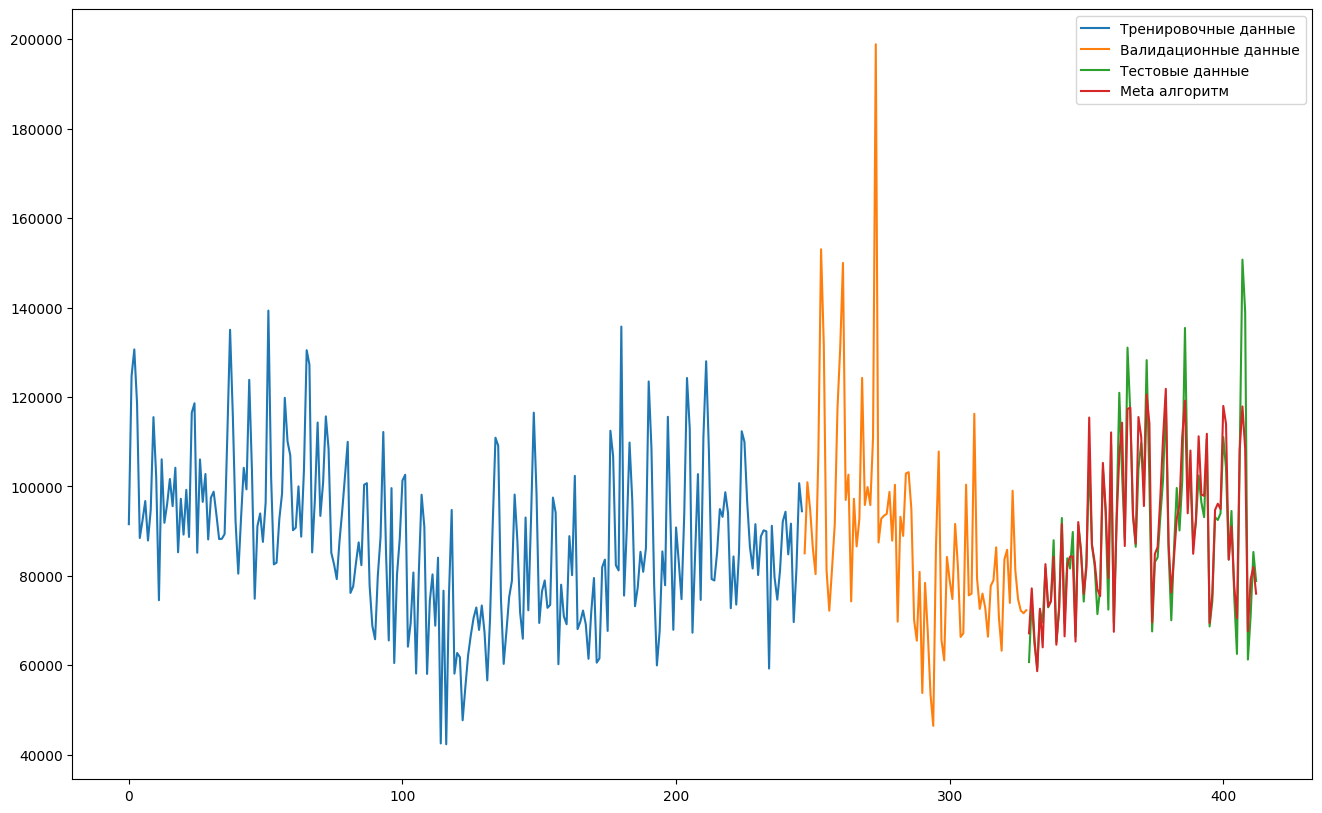

In [253]:
plt.figure(figsize = (16, 10))
plt.plot(y_train, label = "Тренировочные данные")
plt.plot(y_val, label = "Валидационные данные")
plt.plot(y_test, label = "Тестовые данные")
plt.plot(pred_plot, label = "Meta алгоритм")
plt.legend()
plt.show()